<a href="https://colab.research.google.com/github/terse-o/Analyzing-Team-Meetings/blob/main/Transcript_NLP_PROD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.text import Text  
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.probability import FreqDist
import seaborn as sns
import re, string
from matplotlib import pyplot as plt
from mlxtend.preprocessing import minmax_scaling
import numpy as np
from textblob import TextBlob
from scipy import stats
from shapely.geometry.polygon import LinearRing, Polygon
from descartes import PolygonPatch
from IPython.display import display, Image
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import chi2





In [ ]:
!pip install -q xlrd
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
def TextToDf(teamNumber):
  filename = "TeamID_"+ str(teamNumber) +"_transcript.txt"
  transcript = open(filename, "r").read()
  split_text = transcript.split("\n")
  while("" in split_text) : 
      split_text.remove("")
  df = pd.DataFrame(split_text, columns=['Lines'])
  for i in range(len(split_text)-1):
    if not split_text[i][:1].isdigit():
      split_text[i-1] = split_text[i-1]+split_text[i]
  df = pd.DataFrame(split_text, columns=['Lines'])
  dn = df.dropna()
  #preprocessing
  dn['Lines'] = df['Lines'].str.replace('>>',' ')
  dn['Lines'] = dn['Lines'].str.replace('>',' ')
  dn['Lines'] = dn['Lines'].str.replace(':',' ')
  dn['Lines'] = dn['Lines'].str.strip()
  dn['Lines'] = dn['Lines'].str.lower()
  new = dn["Lines"].str.split(" ", n = 3, expand = True)
  new = new.drop(new.columns[1], axis=1)
  new.columns = ['time_stamp', 'person', 'line']
  person = ['person1', 'person2', 'person3', 'person4', 'person5']
  #exception handling
  for i, row in new.iterrows():
    if new['person'][i] not in person:
      new = new.drop([i])
  return new

In [ ]:
def no_punct(text):
  no_punct = "".join([c for c in text if c not in string.punctuation])
  return no_punct

def tokenizewords(text):
    tokenized_words = word_tokenize(text)
    return(tokenized_words)

def contribution(frame):
    return(frame['person'].value_counts())

def plotspeech(frame):
    frame["person"] = frame["person"].astype('category')
    frame["line"]= frame["line"].astype(str)
    frame["line"] = frame["line"].str.len()
    sns.catplot(x = "person", y = "line", hue = "person", kind = "swarm", data = frame)

In [ ]:
#Calculate mean contribution score for team
def calc_mean_contri(teamNumber):
  while (teamNumber > 0 & teamNumber <= 22):
    j = sum(size[:teamNumber-1])
    k = size[teamNumber-1]
    return contri_resp.loc[j+1:j+k, 'Q5m1':'Q5m5'].mean()



In [ ]:
#Calculate mean leadership score for team
def calc_mean_leader(teamNumber):
  #  while (teamNumber > 0 & teamNumber <= 22)
    j = sum(size[:teamNumber-1])
    k = size[teamNumber-1]
    return leader_resp.loc[j+1:j+k, 'Q6m1':'Q6m5'].mean()

In [ ]:
def plotspeech_contri(new_frame, mean_contri):
  #scaling mean contribution score
  q = pd.DataFrame(mean_contri)
  s = ['person1','person2','person3','person4','person5']
  q = q.set_index([s])
  q = q.dropna()
  q = q.reset_index()
  q.columns = ['person', 'con_score']
  q['con_score'] = q['con_score'] * 100

  #plotting speech
  new_frame["person"] = new_frame["person"].astype('category')
  new_frame["line"]= new_frame["line"].astype(str)
  new_frame["line"] = new_frame["line"].str.len()

  ax1 = sns.catplot(x = "person", y = "line", hue = "person", kind = "swarm", data = new_frame)
  ax2 = sns.lineplot(x='person', y='con_score', data=q, legend = False)
  ax2.set_ylim(ymin=0)

In [ ]:
#word frequency
def tf(frame, word):
  string = frame["line"]
  concat_string = string.str.cat(sep = " ")
  text_list = concat_string.split(" ")
  freqDist = FreqDist(text_list)
  count = 0
  for ch in word:
    count = count + freqDist[ch]
  return count

In [ ]:
sw = stopwords.words('english')
sw.remove('and')
sw.remove('than')
sw.remove('or')
sw.remove('but')
sw = sw[8:]
def clean_text(text):
  #text = text.lower()
  text = re.sub('@', '', text)
  text = re.sub('\[.*?\]', '', text)
  text = re.sub('https?://\S+|www\.\S+', '', text)
  text = re.sub('<.*?>+', '', text)
  text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
  text = re.sub('\n', '', text)
  text = re.sub('\w*\d\w*', '', text)
  text = re.sub(r"[^a-zA-Z ]+", "", text)
  
    #Tokenize the data
  text = nltk.word_tokenize(text)
  #Remove stopwords
  text = [w for w in text if w not in sw]
  return text

In [ ]:
lemmatizer = WordNetLemmatizer()
def lem(text):
  text = [lemmatizer.lemmatize(t) for t in text]
  text = [lemmatizer.lemmatize(t, 'v') for t in text]
  return text


In [ ]:
def lexical_dispersion(teamNumber):
  new_frame = TextToDf(teamNumber)
  new_frame['line'] = new_frame['line'].astype('str')
  new_frame['line'] = new_frame['line'].apply(lambda x: clean_text(x))
  new_frame['line'] = new_frame['line'].apply(lambda x: lem(x))
  strng = new_frame["line"]
  strng = strng.reset_index()
  strng = strng.drop(['index'], axis = 1)
  con = list()
  for i in range(len(strng)):
    con = con + strng['line'][i]
  mytext = nltk.Text(con)
  mytext.dispersion_plot(['yeah', 'yes', 'and', 'okay', 'mhm', 'right', 'but', 'or', 'than', 'how', 'i', "dont", 'know', 'think']) #, 'we', 'how', 

In [ ]:
#Familiarity Score
def calc_fam_score(teamNumber):
  ffamiliarity = familiarity.astype(float)
  while (teamNumber > 0 & teamNumber <= 22):
    j = sum(size[:teamNumber-1])
    k = size[teamNumber-1]
    fam = ffamiliarity.loc[j+1:j+k, 'Q4m1':'Q4m5'].sum()
    fam_sum = sum(fam)
    fam_tot = ((k * k) - k)*5
    fam_score = (fam_sum/fam_tot)*100
    return fam_score

In [ ]:
#Engagement Score
def calc_eng_score(teamNumber):
  while (teamNumber > 0 & teamNumber <= 22):
    j = sum(size[:teamNumber-1])
    k = size[teamNumber-1]
    eng = sum(perc_engage.loc[j+1:j+k, 'Q7p1':'Q7p5'].sum())
    eng_tot = (k * 5)*5
    eng_score = (eng/eng_tot)*100
    return eng_score  

In [ ]:
#Calculating delayed response quotient
def response_delay_quo(teamNumber):
  new_frame = TextToDf(teamNumber)
  new_frame = new_frame.reset_index()
  new_frame = new_frame.drop(['index'], axis = 1)
  emp_detect = pd.DataFrame(new_frame['time_stamp'])
  emp_detect['person'] = new_frame['person']
  emp_detect['person'] = emp_detect['person'].astype('category')
  emp_detect['time_stamp'] = emp_detect['time_stamp'].astype('float')
  emp_detect['resp_diff'] = emp_detect['resp_delay'] = None

  #Calculate response time difference
  for i in range(len(emp_detect)-1):
    emp_detect['resp_diff'][i] = emp_detect['time_stamp'][i+1] - emp_detect['time_stamp'][i]
  #Flagging responses above average delays
  for i in range(len(emp_detect)-1):
    if emp_detect['resp_diff'][i] > emp_detect['resp_diff'].mean():
      emp_detect['resp_delay'][i] = 1
    else:
      emp_detect['resp_delay'][i] = 0

  count = emp_detect['resp_delay'].value_counts()
  resp_quo = count[1]/count[0]

  return resp_quo

In [ ]:
def sentimental_analysis_team(teamNumber):
  # Text Preprocessing
  new_frame = TextToDf(teamNumber)
  new_frame['line'] = new_frame['line'].astype('str')
  new_frame['line'] = new_frame['line'].apply(lambda x: clean_text(x))
  new_frame['line'] = new_frame['line'].apply(lambda x: lem(x))
  #line = new_frame['line']
  new_frame=new_frame.reset_index(drop=True)

  #unique categories
  uni_per = new_frame['person'].unique()
  uni_per = sorted(uni_per)

  #Get sentiment from lines - Per team - Unit testing
  new_frame['line'] = [str(thing) for thing in new_frame['line']]
  fig, axs = plt.subplots(1, len(uni_per), figsize=(22, 3))
  for i in range(len(uni_per)):
    result_df = new_frame.loc[new_frame['person'] == uni_per[i]]
    result_df = result_df.reset_index()
    result_df = result_df.drop(['index'], axis = 1)
    sentiment = []
    for j in range(len(result_df)):
      blob = TextBlob(result_df['line'][j])
      for sentence in blob.sentences:
        sentiment.append(sentence.sentiment.polarity)
    result_df['sentiment']=sentiment
    #Plot
    result_df['sentiment'].plot.hist(color='salmon', title='Comments Polarity',ax = axs[i])
    axs[i].set_xlabel(uni_per[i])
    axs[i].set_ylim([0,120])
    axs[i].set_xlim([-1,1])

In [ ]:
def words_per_minute(teamNumber):
  new_frame = TextToDf(teamNumber)
  new_frame['line'] = new_frame['line'].astype(str)
  new_frame['line'] = new_frame['line'].apply(lambda x: clean_text(x))
  new_frame['time_stamp'] = new_frame['time_stamp'].astype('float')
  new_frame = new_frame.reset_index(drop=True)
  #Words per minute
  words = 0
  buffer = 1
  min = []
  for i in range(len(new_frame)):
    if (new_frame['time_stamp'][i]/60 <= buffer):
      words += len(new_frame['line'][i])
    else:
      min.append(words)
      words = 0
      words += len(new_frame['line'][i])
      buffer += 1
  
  return min

In [ ]:
def words_per_person(teamNumber):
  new_frame = TextToDf(teamNumber)
  new_frame['line'] = new_frame['line'].astype(str)
  new_frame['line'] = new_frame['line'].apply(lambda x: clean_text(x))
  new_frame['time_stamp'] = new_frame['time_stamp'].astype('float')
  new_frame = new_frame.reset_index(drop=True)

  #Words per minute
  words_p1 = words_p2 = words_p3 = words_p4 = words_p5 = 0
  buffer = 1
  min_p1 = []
  min_p2 = []
  min_p3 = []
  min_p4 = []
  min_p5 = []
  for i in range(len(new_frame)):
    if (new_frame['time_stamp'][i]/60 <= buffer):
      if (new_frame['person'][i] == 'person1'):
        words_p1 += len(new_frame['line'][i])
      elif (new_frame['person'][i] == 'person2'):
        words_p2 += len(new_frame['line'][i])
      elif (new_frame['person'][i] == 'person3'):
        words_p3 += len(new_frame['line'][i])
      elif (new_frame['person'][i] == 'person4'):
        words_p4 += len(new_frame['line'][i])
      elif (new_frame['person'][i] == 'person5'):
        words_p5 += len(new_frame['line'][i])
    else:
      min_p1.append(words_p1)
      min_p2.append(words_p2)
      min_p3.append(words_p3)
      min_p4.append(words_p4)
      min_p5.append(words_p5)
      words_p1 = words_p2 = words_p3 = words_p4 = words_p5 = 0
      if (new_frame['person'][i] == 'person1'):
        words_p1 += len(new_frame['line'][i])
      elif (new_frame['person'][i] == 'person2'):
        words_p2 += len(new_frame['line'][i])
      elif (new_frame['person'][i] == 'person3'):
        words_p3 += len(new_frame['line'][i])
      elif (new_frame['person'][i] == 'person4'):
        words_p4 += len(new_frame['line'][i])
      elif (new_frame['person'][i] == 'person5'):
        words_p5 += len(new_frame['line'][i])

      buffer += 1
  min_team = [min_p1, min_p2, min_p3, min_p4, min_p5]
  min_team = min_team[:size[teamNumber-1]]
  wr = pd.DataFrame(min_team)
  wr = wr.transpose()
  wr.index = wr.index + 1

  return wr

In [ ]:
# def plot_engagement_polygon(teamNumber):
#   jet= plt.get_cmap('hsv')  #hot
#   colors = iter(jet(np.linspace(0,1,10)))
#   while (teamNumber > 0 & teamNumber <= 22):
#     j = sum(size[:teamNumber-1])
#     k = size[teamNumber-1]
#     yeah = perc_eng[j:j+k]
#     yeah = yeah.reset_index()
#     yeah = yeah.drop(['index'], axis = 1)
#     for id in range(k):
#       fig = plt.figure(1, figsize=(5,5), dpi=90)
#       ring_mixed = Polygon([(yeah['Engage'][id], yeah['Engage'][id]), (yeah['Warm'][id], yeah['Zero'][id]), (yeah['Comfort'][id], yeah['Invert'][id]), (yeah['Zero'][id], yeah['Interest'][id])])
#       ax = fig.add_subplot(111)
#       ring_patch = PolygonPatch(ring_mixed, fc = next(colors), alpha=0.5, zorder=2)
#       ax.add_patch(ring_patch)
#       ax.set_title('Engagement Polygon')
#       xrange = [-2, 2]
#       yrange = [-2, 2]
#       ax.set_xlim(*xrange)
#       ax.set_ylim(*yrange)
#       ax.grid(True)
#       plt.xlabel("Unpleasant ----> Pleasant")
#       plt.ylabel("Activation Low ----> Activation High")
#       plt.legend(['person1', 'person2', 'person3', 'person4', 'person5'])


In [ ]:
#Cleaned data - All metrics
all_metrics = pd.read_excel('all_metrics_new.xlsx')
all_metrics.columns = all_metrics.columns.str.replace(' ', '')
all_metrics = all_metrics[:86]
all_metrics


,TeamID,ParticipantID,Date,task#,atr,atg,atq,atc,atc_2ppl,atc_atleast_2,mutual_gaze,lookatspkr,lookatpaper,lookatotherpart,lookelsewhere,nospkrlookatpaper,nospkrlookatothers,nospkrlookelsewhere,spkrlookatotherspkrs,spkrlookatpaper,spkrlookatothers,spkrlookelsewhere,avg_leader_score,avg_contribution_Score,spknglength,frac_succ_interruptions,frac_backchannels,spkngturns,tf-idf,avginformativeness,numberofsentences,fractiontf-idf,fractionavginfo,fractionnumberofsentences,DM,RFM,DMP,DMS,ITP,RAP,GroupSize,ParticipantIndex,Q8.Gender,Gender
0,1.0,1.0,2017-10-16,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,1.0,M,0
1,1.0,2.0,2017-10-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,2.0,M,0
2,1.0,3.0,2017-10-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.333333,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3.0,F,1
3,1.0,4.0,2017-10-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.333333,3.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.0,M,0
4,2.0,1.0,2017-10-16,2.0,0.028295,0.429148,0.263239,0.000000,0.011175,0.011175,0.018875,0.555891,0.438671,0.005438,0.0,0.712279,0.287721,0.0,0.140351,0.666040,0.193609,0.0,3.666667,4.333333,0.296600,0.326316,0.145833,0.274920,103.577391,1.101887,94.0,0.287998,0.244101,0.294671,0.413793,0.357135,0.333333,1.0,0.2,0.066667,4.0,1.0,F,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,22.0,1.0,2017-10-20,5.0,0.101465,0.420412,1.069751,0.013322,0.086670,0.100911,0.051604,0.514855,0.394967,0.090178,0.0,0.693775,0.290924,0.0,0.847332,0.138822,0.008123,0.0,4.250000,4.000000,0.219313,0.142857,0.054054,0.206897,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,1.0,M,0
82,22.0,2.0,2017-10-20,NaN,0.058419,0.070745,3.660173,0.013935,0.031621,0.048006,0.001608,0.007324,0.992676,0.000000,0.0,0.974638,0.023894,0.0,0.121259,0.877667,0.001074,0.0,2.750000,3.750000,0.135496,0.171429,0.081081,0.136432,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,2.0,F,1
83,22.0,3.0,2017-10-20,NaN,0.015909,0.298139,0.236518,0.002297,0.011561,0.013858,0.007810,0.132969,0.838798,0.028233,0.0,0.668623,0.331377,0.0,0.283231,0.703003,0.013765,0.0,2.500000,3.250000,0.083817,0.085714,0.081081,0.080960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,3.0,M,0
84,22.0,4.0,2017-10-20,NaN,0.129897,0.238879,2.410256,0.025113,0.102060,0.128857,0.044637,0.176684,0.775564,0.047752,0.0,0.873192,0.126808,0.0,0.502030,0.480379,0.017591,0.0,3.250000,4.000000,0.464351,0.371429,0.621622,0.359820,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,4.0,M,0


In [ ]:
### Post Task Responses
post = pd.read_excel('Post_Task_Rankings.xlsx')
new_header = post.iloc[0]
post = post[1:]
post.columns = new_header
post.columns = post.columns.str.replace(' ', '')

post

,TeamID,ParticipantID,GroupSize,Matches,Food,Rope,Parachute,Heating,Pistols,Milk,Oxygen,Map,Raft,Compass,Water,Flares,FirstAid,FM,NotRanked,Matches,Food,Rope,Parachute,Heating,Pistols,Milk,Oxygen,Map,Raft,Compass,Water,Flares,FirstAid,FM,NotRanked,Q1,Q2,Q3,Q3Desc,Q4m1,Q4m2,Q4m3,Q4m4,Q4m5,Q5m1,Q5m2,Q5m3,Q5m4,Q5m5,Q6m1,Q6m2,Q6m3,Q6m4,Q6m5,Q7p1,Q7p2,Q7p3,Q7p4,Q7p5,Q8.Gender,Q9.Race,Q10.Age
1,1,1,4,14,4,6,10,7,13,11,1,5,8,15,2,12,9,3,NaN,13,NaN,NaN,NaN,NaN,15,NaN,1,4,12,14,3,5,NaN,2,NaN,1,2,0,NaN,NaN,1,1,1,NaN,3,4,3,3,NaN,4,5,3,3,NaN,3,3,5,4,4,M,White,27
2,1,2,4,14,8,9,12,5,15,11,2,7,13,6,3,4,10,1,NaN,13,NaN,NaN,NaN,NaN,15,NaN,1,4,12,14,3,5,NaN,2,NaN,0,3,0,NaN,1,NaN,1,2,NaN,3,4,3,4,NaN,3,3,2,3,NaN,4,3,4,4,4,M,White,20
3,1,3,4,15,10,6,12,7,14,13,1,2,11,5,3,8,9,4,NaN,13,NaN,NaN,NaN,NaN,15,NaN,1,4,12,14,3,5,NaN,2,NaN,1,3,0,NaN,1,1,NaN,3,NaN,3,4,4,4,NaN,3,4,4,4,NaN,5,4,4,5,4,F,Asian,20
4,1,4,4,8,3,10,14,4,15,12,1,6,13,7,2,9,5,11,NaN,13,NaN,NaN,NaN,NaN,15,NaN,1,4,12,14,3,5,NaN,2,NaN,0,3,0,NaN,1,2,3,NaN,NaN,3,4,3,3,NaN,3,3,2,2,NaN,5,4,4,5,5,M,White/Hispanic,20
5,2,1,4,6,3,13,11,5,14,15,1,7,12,8,2,10,9,4,NaN,15,6,7,11,5,14,13,1,3,12,10,2,9,8,4,NaN,0,3,1,I've been involved with many leadership/group ...,NaN,1,1,2,NaN,5,4,4,5,NaN,5,3,3,5,NaN,5,4,5,5,5,F,Asian,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,22,1,5,6,3,11,15,7,5,8,1,10,14,9,2,12,4,13,NaN,NaN,3,NaN,NaN,5,15,NaN,1,6,14,4,2,NaN,NaN,NaN,NaN,0,4,0,NaN,NaN,1,3,1,3,4,4,3,4,4,4,3,2,4,3,4,4,5,5,5,M,Asian,18
83,22,2,5,6,3,8,9,5,14,15,1,12,13,11,2,7,10,4,NaN,NaN,3,NaN,NaN,5,15,NaN,1,6,14,3,2,NaN,NaN,NaN,NaN,0,3,0,NaN,1,NaN,1,1,1,4,4,3,5,4,5,3,3,4,3,5,4,4,5,4,F,Asian,22
84,22,3,5,12,3,6,14,5,13,11,1,7,15,4,2,10,9,8,NaN,NaN,3,NaN,NaN,5,NaN,NaN,2,6,14,4,2,NaN,NaN,NaN,NaN,0,3,0,NaN,3,1,NaN,1,3,4,4,4,3,3,4,3,3,3,3,4,4,4,5,5,M,Asian,18
85,22,4,5,6,4,12,14,5,15,11,1,10,13,2,3,8,9,7,NaN,NaN,3,NaN,NaN,5,15,NaN,1,6,14,4,2,NaN,NaN,NaN,NaN,0,3,0,NaN,1,1,1,NaN,1,4,4,4,4,4,4,3,3,3,4,5,5,5,5,5,M,Asian,26


In [ ]:
team_id = post['TeamID'].unique()
#Segmenting dataset
team_info = post.loc[:,'TeamID':'GroupSize']
knowledge = post.loc[:, 'Q2']
skill = post.loc[:, 'Q3']
familiarity = post.loc[:, 'Q4m1':'Q4m5']
perc_contri = post.loc[:, 'Q5m1':'Q5m5']
perc_leader = post.loc[:, 'Q6m1':'Q6m5']
perc_engage = post.loc[:, 'Q7p1':'Q7p5']
demographic = post.loc[:, 'Q8.Gender':'Q10.Age']

In [ ]:
#Contribution #####################################################################################################################################################
nrow = team_info.shape[0]
nrow

86

In [ ]:
#Get team sizes
size = []
i = 1
while i < (nrow):
  grp_size = 0
  grp_size = team_info['GroupSize'].iloc[i]
  size.append(grp_size)
  i += grp_size - 1
  i += 1
size

[4, 4, 4, 4, 4, 5, 3, 5, 3, 4, 3, 3, 4, 4, 4, 4, 3, 4, 3, 4, 5, 5]

In [ ]:
#Extracting Attention Quotient
attention = round(all_metrics['atq'], 2)
attention[81:86]

81    1.07
82    3.66
83    0.24
84    2.41
85    0.03
Name: atq, dtype: float64

In [ ]:
#Extracting Participation - Speech Lenghts
parti = []
for i in range(1,23):
  df = TextToDf(i)  
  df["person"] = df["person"].astype('category')
  df["line"]= df["line"].astype(str)
  df["line"] = df["line"].str.len()
  df.dropna()
  df=df.reset_index(drop=True)
  yo = df.groupby(['person']).sum()
  yo = yo.reset_index()
  for j in range(size[i-1]):
    parti.append(yo['line'][j])

parti

[3188,
 5014,
 2122,
 1835,
 4460,
 3977,
 3327,
 3430,
 3203,
 4127,
 1737,
 2888,
 3374,
 2021,
 5128,
 1316,
 2004,
 1840,
 6935,
 1385,
 4934,
 2478,
 3369,
 243,
 1133,
 4314,
 3393,
 2558,
 3034,
 2952,
 4286,
 3654,
 3041,
 2209,
 3043,
 6773,
 1620,
 4294,
 1828,
 2118,
 2611,
 929,
 2208,
 2907,
 3551,
 2899,
 5784,
 2804,
 4159,
 403,
 2311,
 1615,
 7134,
 1895,
 1623,
 4074,
 1716,
 2019,
 2611,
 2354,
 5727,
 3273,
 3764,
 1870,
 6817,
 1358,
 2961,
 1999,
 5192,
 7731,
 1780,
 4920,
 5156,
 1071,
 2908,
 5315,
 2897,
 7103,
 6360,
 2712,
 1304,
 4350,
 2113,
 1331,
 2687,
 4365]

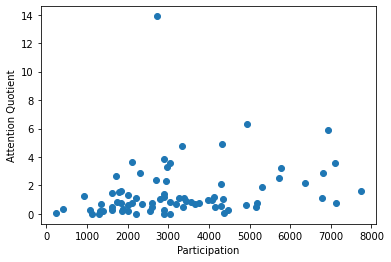

In [ ]:
awesome = pd.DataFrame(parti, attention)
awesome = awesome.reset_index()
awesome = awesome.rename(columns={'atq' : 'Atq', 0 : 'participate'})
awesome = awesome.dropna()

#Removing Outliers
z_scores = stats.zscore(awesome)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
new_df = awesome[filtered_entries]

#Plotting Atq v/s Participation
plt.scatter(x='participate', y='Atq', data=new_df)
plt.xlabel("Participation")
plt.ylabel("Attention Quotient")
plt.show()

In [ ]:
### WORKSSSS
x_na = lambda df : df.fillna(round(df.mean()))
contri_fillna = []
for s in range(len(size)):
  if s == 0:
    i = 1
  index = i+size[s]-1
  contri_fillna.append(x_na(perc_contri.loc[i:index, 'Q5m1':'Q5m5']))
  i = i + size[s]
  #print(index)

In [ ]:
## Normalized contribution responses
contri_final = pd.concat(contri_fillna)
contri_final
#####################################################################################################################################################################

,Q5m1,Q5m2,Q5m3,Q5m4,Q5m5
1,3.0,4,3,3.0,NaN
2,3.0,4,3,4.0,NaN
3,3.0,4,4,4.0,NaN
4,3.0,4,3,3.0,NaN
5,5.0,4,4,5.0,NaN
...,...,...,...,...,...
82,4.0,4,3,4.0,4.0
83,4.0,4,3,5.0,4.0
84,4.0,4,4,3.0,3.0
85,4.0,4,4,4.0,4.0


In [ ]:
contri_resp = contri_final.astype(float)
contri_resp

,Q5m1,Q5m2,Q5m3,Q5m4,Q5m5
1,3.0,4.0,3.0,3.0,NaN
2,3.0,4.0,3.0,4.0,NaN
3,3.0,4.0,4.0,4.0,NaN
4,3.0,4.0,3.0,3.0,NaN
5,5.0,4.0,4.0,5.0,NaN
...,...,...,...,...,...
82,4.0,4.0,3.0,4.0,4.0
83,4.0,4.0,3.0,5.0,4.0
84,4.0,4.0,4.0,3.0,3.0
85,4.0,4.0,4.0,4.0,4.0


In [ ]:
#Unit test case
team = 22
contri = calc_mean_contri(team)
frame = TextToDf(team)
frame_plot = frame.copy()
frame

,time_stamp,person,line
0,4.09,person1,"okay, so."
1,7.29,person1,i guess we just need to get a starting point. ...
2,10.28,person3,i put the oxygen.
3,12.42,person2,same.
4,12.6,person4,same.
...,...,...,...
347,892.01,person5,"six, okay."
348,894.85,person2,for six? do we all agree on that?
349,896.11,person4,"yeah, map."
350,897.32,person1,okay.


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 24.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 28.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 35.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 15.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 15.8% of the points cannot be placed; y

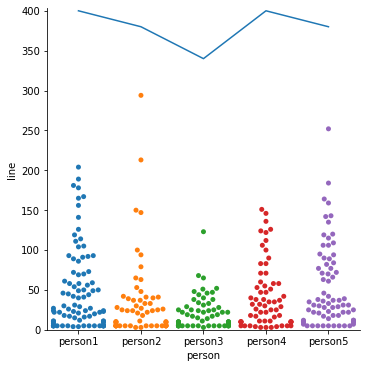

In [ ]:
#Comparing contribution with perceived response
plotspeech_contri(frame_plot, contri)

In [ ]:
#Building Contribution Score Board
s = []
for i in range(1,23):
  contri_score = calc_mean_contri(i)
  r = []
  for j in range(size[i-1]):
    r.append(round(contri_score[j],2))
  s.append(r)

In [ ]:
contri_score_board = pd.DataFrame(s)
contri_score_board.columns = ['Q5m1', 'Q5m2', 'Q5m3', 'Q5m4', 'Q5m5']
contri_score_board['Q5m1'][10] = round(contri_score_board['Q5m1'].mean(),2)
contri_score_board

,Q5m1,Q5m2,Q5m3,Q5m4,Q5m5
0,3.00,4.00,3.25,3.50,NaN
1,4.50,4.00,3.75,4.25,NaN
2,4.25,4.00,4.00,3.75,NaN
3,4.25,4.25,4.50,4.25,NaN
4,3.75,3.25,5.00,2.75,NaN
5,4.60,3.40,4.20,2.00,2.6
6,4.00,4.00,4.00,NaN,NaN
7,4.20,4.20,4.40,4.20,4.4
8,4.33,4.33,4.33,NaN,NaN
9,4.25,4.25,4.25,4.25,NaN


In [ ]:
#Transposing each row to single column
contri_array = []
for i in range(22):
  contri_slice = contri_score_board.loc[i]
  for j in range(size[i]):
    contri_array.append(contri_slice[j])
contri_array

[3.0,
 4.0,
 3.25,
 3.5,
 4.5,
 4.0,
 3.75,
 4.25,
 4.25,
 4.0,
 4.0,
 3.75,
 4.25,
 4.25,
 4.5,
 4.25,
 3.75,
 3.25,
 5.0,
 2.75,
 4.6,
 3.4,
 4.2,
 2.0,
 2.6,
 4.0,
 4.0,
 4.0,
 4.2,
 4.2,
 4.4,
 4.2,
 4.4,
 4.33,
 4.33,
 4.33,
 4.25,
 4.25,
 4.25,
 4.25,
 4.1,
 4.0,
 4.0,
 5.0,
 5.0,
 4.67,
 4.25,
 4.25,
 4.5,
 2.25,
 3.5,
 3.5,
 4.25,
 3.25,
 4.25,
 4.5,
 4.25,
 4.0,
 3.5,
 4.0,
 4.0,
 4.0,
 4.0,
 4.33,
 4.67,
 3.75,
 3.5,
 4.0,
 4.0,
 4.67,
 3.0,
 4.0,
 4.5,
 3.0,
 4.25,
 4.25,
 3.6,
 4.4,
 4.2,
 3.4,
 2.4,
 4.0,
 3.8,
 3.4,
 4.0,
 3.8]

In [ ]:
## Equal contribution
eq_par = []
for i in range(1,23):
  df = TextToDf(i)  
  df["person"] = df["person"].astype('category')
  df["line"]= df["line"].astype(str)
  df["line"] = df["line"].str.len()
  df.dropna()
  df=df.reset_index(drop=True)
  participate = df.groupby(['person']).sum()
  par = round(participate.std(),2)
  eq_par.append(par['line'])

eq_par

[1439.14,
 525.21,
 986.33,
 1678.9,
 2609.17,
 1845.21,
 878.35,
 572.9,
 2430.31,
 1236.32,
 878.2,
 374.14,
 2276.41,
 2612.53,
 1156.43,
 1539.96,
 2496.03,
 1677.75,
 2977.02,
 2019.61,
 2515.65,
 1355.66]

In [ ]:
#Leadership #####################################################################################################################################################

leader_fillna = []
for s in range(len(size)):
  if s == 0:
    i = 1
  index = i+size[s]-1
  leader_fillna.append(x_na(perc_leader.loc[i:index, 'Q6m1':'Q6m5']))
  i = i + size[s]
  #print(index)


In [ ]:
leader_final = pd.concat(leader_fillna)
leader_resp = leader_final.astype(float)
leader_resp

,Q6m1,Q6m2,Q6m3,Q6m4,Q6m5
1,4.0,5.0,3.0,3.0,NaN
2,3.0,3.0,2.0,3.0,NaN
3,3.0,4.0,4.0,4.0,NaN
4,3.0,3.0,2.0,2.0,NaN
5,5.0,3.0,3.0,5.0,NaN
...,...,...,...,...,...
82,4.0,3.0,2.0,4.0,3.0
83,5.0,3.0,3.0,4.0,3.0
84,4.0,3.0,3.0,3.0,3.0
85,4.0,3.0,3.0,3.0,4.0


In [ ]:
#Unit test case
team = 8
leader_score = calc_mean_leader(team)
leader_score

0
Q6m1    2.6
Q6m2    2.4
Q6m3    3.0
Q6m4    2.6
Q6m5    2.2
dtype: float64

In [ ]:
#Building Leadership Score Board
b = []
for i in range(1,23):
  leader_score = calc_mean_leader(i)
  a = []
  for j in range(size[i-1]):
    a.append(round(leader_score[j],2))
  b.append(a)

In [ ]:
leader_score_board = pd.DataFrame(b)
leader_score_board.columns = ['Q6m1', 'Q6m2', 'Q6m3', 'Q6m4', 'Q6m5']
leader_score_board['Q6m1'][10] = round(leader_score_board['Q6m1'].mean(),2)
leader_score_board

,Q6m1,Q6m2,Q6m3,Q6m4,Q6m5
0,3.25,3.75,2.75,3.00,NaN
1,4.00,3.00,2.75,3.25,NaN
2,3.25,3.50,3.00,2.75,NaN
3,3.75,2.50,4.25,3.00,NaN
4,3.00,2.25,4.50,1.62,NaN
5,4.20,3.20,3.60,1.60,1.8
6,3.00,2.67,2.67,NaN,NaN
7,2.60,2.40,3.00,2.60,2.2
8,2.67,3.33,3.00,NaN,NaN
9,3.75,4.00,3.75,3.00,NaN


In [ ]:
#Transposing each row to single column
leader_array = []
for i in range(22):
  leader_slice = leader_score_board.loc[i]
  for j in range(size[i]):
    leader_array.append(leader_slice[j])
leader_array

[3.25,
 3.75,
 2.75,
 3.0,
 4.0,
 3.0,
 2.75,
 3.25,
 3.25,
 3.5,
 3.0,
 2.75,
 3.75,
 2.5,
 4.25,
 3.0,
 3.0,
 2.25,
 4.5,
 1.62,
 4.2,
 3.2,
 3.6,
 1.6,
 1.8,
 3.0,
 2.67,
 2.67,
 2.6,
 2.4,
 3.0,
 2.6,
 2.2,
 2.67,
 3.33,
 3.0,
 3.75,
 4.0,
 3.75,
 3.0,
 3.2,
 4.0,
 3.67,
 2.0,
 2.67,
 2.33,
 3.75,
 3.5,
 4.0,
 1.0,
 2.25,
 2.0,
 3.5,
 2.25,
 3.0,
 3.5,
 3.25,
 3.25,
 2.5,
 3.25,
 4.0,
 3.5,
 3.0,
 2.67,
 3.67,
 3.25,
 3.0,
 3.0,
 3.75,
 3.33,
 2.0,
 3.0,
 3.75,
 2.0,
 3.25,
 4.0,
 2.8,
 4.0,
 3.8,
 2.8,
 1.6,
 4.2,
 2.8,
 2.6,
 3.2,
 3.2]

In [ ]:
#Engagement #####################################################################################################################################################
perc_engage.isnull().values.any()

True

In [ ]:
perc_engage = perc_engage.fillna(perc_engage.mean())
perc_engage = perc_engage.astype(float)
perc_engage

,Q7p1,Q7p2,Q7p3,Q7p4,Q7p5
1,3.0,3.0,5.0,4.0,4.0
2,4.0,3.0,4.0,4.0,4.0
3,5.0,4.0,4.0,5.0,4.0
4,5.0,4.0,4.0,5.0,5.0
5,5.0,4.0,5.0,5.0,5.0
...,...,...,...,...,...
82,4.0,4.0,5.0,5.0,5.0
83,5.0,4.0,4.0,5.0,4.0
84,4.0,4.0,4.0,5.0,5.0
85,5.0,5.0,5.0,5.0,5.0


In [ ]:
#Unit test case
team = 1
engage_score = calc_eng_score(team)
engage_score

83.0

In [ ]:
#Building Engagement Score Array
engage_score = []
for i in range(1,23):
  engage_score.append(round(calc_eng_score(i),2))
engage_score

[83.0,
 89.0,
 88.0,
 96.0,
 57.0,
 81.04,
 80.0,
 91.2,
 81.33,
 90.0,
 84.0,
 96.0,
 78.0,
 93.0,
 97.0,
 94.0,
 76.0,
 89.0,
 76.0,
 87.0,
 84.8,
 91.2]

In [ ]:
eng_array = []
for i in range(1,87):
  eng_m_sum = perc_engage.loc[i].sum()
  eng_array.append(round((eng_m_sum/(25))*100,2))
eng_array

[76.0,
 76.0,
 88.0,
 92.0,
 96.0,
 84.0,
 100.0,
 76.0,
 96.0,
 84.0,
 76.0,
 96.0,
 100.0,
 100.0,
 100.0,
 84.0,
 36.0,
 48.0,
 64.0,
 80.0,
 97.18,
 84.0,
 100.0,
 40.0,
 84.0,
 72.0,
 84.0,
 84.0,
 92.0,
 88.0,
 92.0,
 100.0,
 84.0,
 92.0,
 72.0,
 80.0,
 96.0,
 88.0,
 100.0,
 76.0,
 84.0,
 84.0,
 84.0,
 88.0,
 100.0,
 100.0,
 80.0,
 64.0,
 92.0,
 76.0,
 92.0,
 92.0,
 92.0,
 96.0,
 96.0,
 92.0,
 100.0,
 100.0,
 92.0,
 92.0,
 96.0,
 96.0,
 76.0,
 84.0,
 68.0,
 92.0,
 92.0,
 92.0,
 80.0,
 92.0,
 68.0,
 68.0,
 96.0,
 60.0,
 100.0,
 92.0,
 76.0,
 100.0,
 80.0,
 88.0,
 80.0,
 92.0,
 88.0,
 88.0,
 100.0,
 88.0]

In [ ]:
#Engagement Polygon #################################################################################################################################################
perc_eng = perc_engage.drop(['Q7p5'], axis = 1)
perc_eng

,Q7p1,Q7p2,Q7p3,Q7p4
1,3.0,3.0,5.0,4.0
2,4.0,3.0,4.0,4.0
3,5.0,4.0,4.0,5.0
4,5.0,4.0,4.0,5.0
5,5.0,4.0,5.0,5.0
...,...,...,...,...
82,4.0,4.0,5.0,5.0
83,5.0,4.0,4.0,5.0
84,4.0,4.0,4.0,5.0
85,5.0,5.0,5.0,5.0


In [ ]:
perc_eng = perc_eng.replace([5.0,4.0,3.0,2.0,1.0],[2,1,0,-1,-2])
perc_eng

,Q7p1,Q7p2,Q7p3,Q7p4
1,0.0,0.0,2.0,1.0
2,1.0,0.0,1.0,1.0
3,2.0,1.0,1.0,2.0
4,2.0,1.0,1.0,2.0
5,2.0,1.0,2.0,2.0
...,...,...,...,...
82,1.0,1.0,2.0,2.0
83,2.0,1.0,1.0,2.0
84,1.0,1.0,1.0,2.0
85,2.0,2.0,2.0,2.0


In [ ]:
perc_eng.columns = ['Engage', 'Warm', 'Comfort', 'Interest']
perc_eng['Zero'] = 0
perc_eng['Invert'] = 0
perc_eng

,Engage,Warm,Comfort,Interest,Zero,Invert
1,0.0,0.0,2.0,1.0,0,0
2,1.0,0.0,1.0,1.0,0,0
3,2.0,1.0,1.0,2.0,0,0
4,2.0,1.0,1.0,2.0,0,0
5,2.0,1.0,2.0,2.0,0,0
...,...,...,...,...,...,...
82,1.0,1.0,2.0,2.0,0,0
83,2.0,1.0,1.0,2.0,0,0
84,1.0,1.0,1.0,2.0,0,0
85,2.0,2.0,2.0,2.0,0,0


In [ ]:
perc_eng['Invert'] = perc_eng['Comfort'] * -1
perc_eng

,Engage,Warm,Comfort,Interest,Zero,Invert
1,0.0,0.0,2.0,1.0,0,-2.0
2,1.0,0.0,1.0,1.0,0,-1.0
3,2.0,1.0,1.0,2.0,0,-1.0
4,2.0,1.0,1.0,2.0,0,-1.0
5,2.0,1.0,2.0,2.0,0,-2.0
...,...,...,...,...,...,...
82,1.0,1.0,2.0,2.0,0,-2.0
83,2.0,1.0,1.0,2.0,0,-1.0
84,1.0,1.0,1.0,2.0,0,-1.0
85,2.0,2.0,2.0,2.0,0,-2.0


In [ ]:
perc_eng = perc_eng.reset_index()
perc_eng = perc_eng.drop(['index'], axis = 1)
perc_eng[0:4]

,Engage,Warm,Comfort,Interest,Zero,Invert
0,0.0,0.0,2.0,1.0,0,-2.0
1,1.0,0.0,1.0,1.0,0,-1.0
2,2.0,1.0,1.0,2.0,0,-1.0
3,2.0,1.0,1.0,2.0,0,-1.0


In [ ]:
from itertools import cycle
cycol = cycle('bgrcmk')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


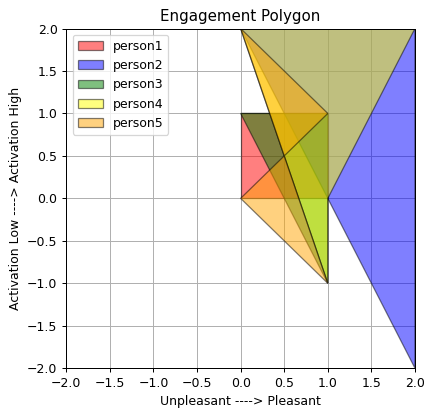

In [ ]:
##############Work In Progress
teamNumber = 21
#jet= plt.get_cmap('hsv')  #hot
#colors = iter(jet(np.linspace(0,1,10)))
colors = ['red', 'blue', 'green', 'yellow', 'orange']
#while (teamNumber > 0 & teamNumber <= 22):
j = sum(size[:teamNumber-1])
k = size[teamNumber-1]
yeah = perc_eng[j:j+k]
yeah = yeah.reset_index()
yeah = yeah.drop(['index'], axis = 1)
team_size = np.arange(k)
for id, color in zip(team_size, colors):
  fig = plt.figure(1, figsize=(5,5), dpi=90)
  ring_mixed = Polygon([(yeah['Engage'][id], yeah['Engage'][id]), (yeah['Warm'][id], yeah['Zero'][id]), (yeah['Comfort'][id], yeah['Invert'][id]), (yeah['Zero'][id], yeah['Interest'][id])])
  ax = fig.add_subplot(111)
  ring_patch = PolygonPatch(ring_mixed, fc = color ,alpha=0.5, zorder=2)
  ax.add_patch(ring_patch)
  ax.set_title('Engagement Polygon')
  xrange = [-2, 2]
  yrange = [-2, 2]
  ax.set_xlim(*xrange)
  ax.set_ylim(*yrange)
  ax.grid(True)
  plt.xlabel("Unpleasant ----> Pleasant")
  plt.ylabel("Activation Low ----> Activation High")
  plt.legend(['person1', 'person2', 'person3', 'person4', 'person5'])


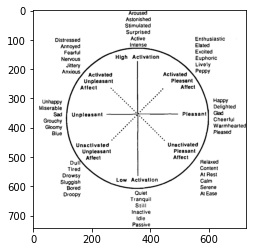

In [ ]:
image = mpimg.imread('Emotion.png')
plt.imshow(image)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

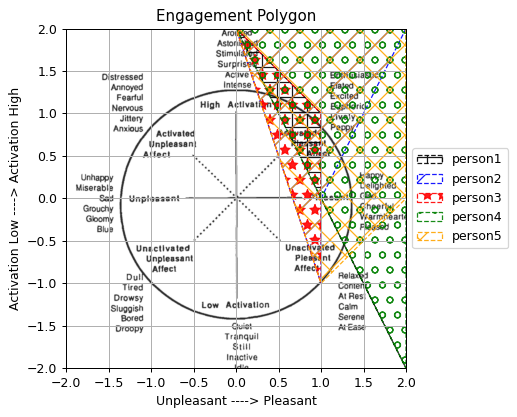

In [ ]:
teamNumber = 22
colors = ['black', 'blue', 'red', 'green', 'orange']
#while (teamNumber > 0 & teamNumber <= 22):
j = int(sum(size[:teamNumber-1]))
k = size[teamNumber-1]
yeah = perc_eng[j:j+k]
yeah = yeah.reset_index()
yeah = yeah.drop(['index'], axis = 1)

for id in range(k):
  fig = plt.figure(1, figsize=(5,5), dpi=90)
  if id == 0:
    ring_mixed = Polygon([(yeah['Engage'][id], yeah['Engage'][id]), (yeah['Warm'][id], yeah['Zero'][id]), (yeah['Comfort'][id], yeah['Invert'][id]), (yeah['Zero'][id], yeah['Interest'][id])])
    ax = fig.add_subplot(111)
    ring_patch = PolygonPatch(ring_mixed, ec = colors[id], fill = False, alpha=0.9, zorder=1, ls = '--', hatch = '+')
    plt.imshow(image, zorder=0, extent=[-2.0,2.1, -2.18, 2.0], alpha=0.3)
    ax.add_patch(ring_patch)
  elif id == 1:
    ring_mixed = Polygon([(yeah['Engage'][id], yeah['Engage'][id]), (yeah['Warm'][id], yeah['Zero'][id]), (yeah['Comfort'][id], yeah['Invert'][id]), (yeah['Zero'][id], yeah['Interest'][id])])
    ax = fig.add_subplot(111)
    ring_patch = PolygonPatch(ring_mixed, ec = colors[id], fill = False, alpha=0.9, zorder=1, ls = '--', hatch = '/')
    plt.imshow(image, zorder=0, extent=[-2.0,2.1, -2.18, 2.0], alpha=0.3)
    ax.add_patch(ring_patch)
  elif id == 2:
    ring_mixed = Polygon([(yeah['Engage'][id], yeah['Engage'][id]), (yeah['Warm'][id], yeah['Zero'][id]), (yeah['Comfort'][id], yeah['Invert'][id]), (yeah['Zero'][id], yeah['Interest'][id])])
    ax = fig.add_subplot(111)
    ring_patch = PolygonPatch(ring_mixed, ec = colors[id], fill = False, alpha=0.9, zorder=1, ls = '--', hatch = '*')
    plt.imshow(image, zorder=0, extent=[-2.0,2.1, -2.18, 2.0], alpha=0.3)
    ax.add_patch(ring_patch)
  elif id == 3:
    ring_mixed = Polygon([(yeah['Engage'][id], yeah['Engage'][id]), (yeah['Warm'][id], yeah['Zero'][id]), (yeah['Comfort'][id], yeah['Invert'][id]), (yeah['Zero'][id], yeah['Interest'][id])])
    ax = fig.add_subplot(111)
    ring_patch = PolygonPatch(ring_mixed, ec = colors[id], fill = False, alpha=0.9, zorder=1, ls = '--', hatch = 'o')
    plt.imshow(image, zorder=0, extent=[-2.0,2.1, -2.18, 2.0], alpha=0.3)
    ax.add_patch(ring_patch)
  elif id == 4:
    ring_mixed = Polygon([(yeah['Engage'][id], yeah['Engage'][id]), (yeah['Warm'][id], yeah['Zero'][id]), (yeah['Comfort'][id], yeah['Invert'][id]), (yeah['Zero'][id], yeah['Interest'][id])])
    ax = fig.add_subplot(111)
    ring_patch = PolygonPatch(ring_mixed, ec = colors[id], fill = False, alpha=0.9, zorder=1, ls = '--', hatch = 'x')
    plt.imshow(image, zorder=0, extent=[-2.0,2.1, -2.18, 2.0], alpha=0.3)
    ax.add_patch(ring_patch)
  ax.set_title('Engagement Polygon')
  xrange = [-2, 2]
  yrange = [-2, 2]
  ax.set_xlim(*xrange)
  ax.set_ylim(*yrange)
  ax.grid(True)
  plt.xlabel("Unpleasant ----> Pleasant")
  plt.ylabel("Activation Low ----> Activation High")
  plt.legend(['person1', 'person2', 'person3', 'person4', 'person5'], loc = 'center left', bbox_to_anchor=(1, 0.5))





In [ ]:
#Knowledge #####################################################################################################################################################
knowl = knowledge.reset_index()
knowl = knowl.drop(['index'], axis = 1)
knowl

,Q2
0,2
1,3
2,3
3,3
4,3
...,...
81,4
82,3
83,3
84,3


In [ ]:
team_know = []
for i in range(1,23):
#  j = sum(size[:i-1])
  k = size[i-1]
  if i == 1:
    l = 0
    team_know.append(sum(knowledge[l:l+k]))
  else:
    team_know.append(sum(knowledge[l:l+k]))
  l = l + k

In [ ]:
# Run only once
for i in range(len(size)):
  weight = size[i]
  team_know[i] = round((team_know[i]/(weight*5))*100,2)
team_know

[55.0,
 45.0,
 25.0,
 55.0,
 50.0,
 56.0,
 33.33,
 40.0,
 33.33,
 70.0,
 40.0,
 40.0,
 45.0,
 55.0,
 65.0,
 45.0,
 60.0,
 50.0,
 46.67,
 40.0,
 60.0,
 68.0]

In [ ]:
#Gender #####################################################################################################################################################
demographic

,Q8.Gender,Q9.Race,Q10.Age
1,M,White,27
2,M,White,20
3,F,Asian,20
4,M,White/Hispanic,20
5,F,Asian,20
...,...,...,...
82,M,Asian,18
83,F,Asian,22
84,M,Asian,18
85,M,Asian,26


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


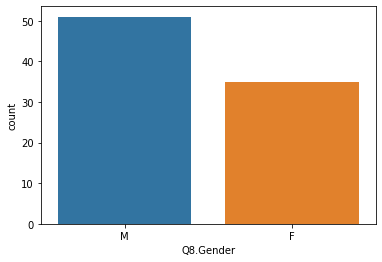

In [ ]:
#Distributions
sns.countplot(demographic['Q8.Gender'])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


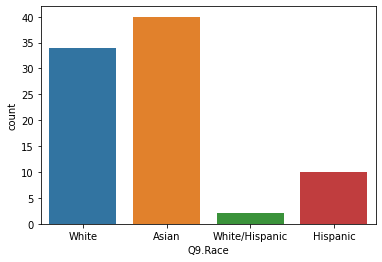

In [ ]:
sns.countplot(demographic['Q9.Race'])

In [ ]:
Gender = demographic['Q8.Gender'].replace(['F','M'],[0,1])

gender_frac = []
for i in range(1,23):
#  j = sum(size[:i-1])
  k = size[i-1]
  if i == 1:
    l = 0
    gender_frac.append(sum(Gender[l:l+k]))
  else:
    gender_frac.append(sum(Gender[l:l+k]))
  l = l + k
gender_frac

[3, 2, 4, 3, 4, 0, 0, 4, 2, 2, 1, 2, 1, 2, 2, 3, 2, 2, 3, 0, 5, 4]

In [ ]:

# Run only once
for i in range(len(size)):
  #weight = size[i]
  gender_frac[i] = round((gender_frac[i]/(size[i]))*100,2)
gender_frac

[75.0,
 50.0,
 100.0,
 75.0,
 100.0,
 0.0,
 0.0,
 80.0,
 66.67,
 50.0,
 33.33,
 66.67,
 25.0,
 50.0,
 50.0,
 75.0,
 66.67,
 50.0,
 100.0,
 0.0,
 100.0,
 80.0]

In [ ]:
gender = Gender.reset_index()
gender = gender.drop(['index'], axis = 1)
gender

,Q8.Gender
0,1
1,1
2,0
3,1
4,0
...,...
81,1
82,0
83,1
84,1


In [ ]:
race = demographic['Q9.Race']
race = race.reset_index()
race = race.drop(['index'], axis = 1)
race = race.astype('category')
race

,Q9.Race
0,White
1,White
2,Asian
3,White/Hispanic
4,Asian
...,...
81,Asian
82,Asian
83,Asian
84,Asian


In [ ]:
diversity = []
team = np.array(race)

for i in range(1,23):
  k = size[i-1]
  if i == 1:
    l = 0
    sum_div = 0
    if 'White' in team[l:l+k]:
      sum_div += 1
    if 'Asian' in team[l:l+k]:
      sum_div += 1
    if 'Hispanic' in team[l:l+k]:
      sum_div += 1
    if 'White/Hispanic' in team[l:l+k]:
      sum_div += 1
    diversity.append(sum_div/4)
  else:
    sum_div = 0
    if 'White' in team[l:l+k]:
      sum_div += 1
    if 'Asian' in team[l:l+k]:
      sum_div += 1
    if 'Hispanic' in team[l:l+k]:
      sum_div += 1
    if 'White/Hispanic' in team[l:l+k]:
      sum_div += 1
    diversity.append(sum_div/4)
  l = l + k

diversity

[0.75,
 0.75,
 0.5,
 0.75,
 0.75,
 0.5,
 0.25,
 0.75,
 0.5,
 0.25,
 0.5,
 0.5,
 0.25,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.25,
 0.75,
 0.5,
 0.25]

In [ ]:

#Skill #####################################################################################################################################################
ski = skill.reset_index()
ski = ski.drop(['index'], axis = 1)
ski

,Q3
0,0
1,0
2,0
3,0
4,1
...,...
81,0
82,0
83,0
84,0


In [ ]:
team_skill = []
for i in range(1,23):
#  j = sum(size[:i-1])
  k = size[i-1]
  if i == 1:
    l = 0
    team_skill.append(sum(skill[l:l+k]))
  else:
    team_skill.append(sum(skill[l:l+k]))
  l = l + k

In [ ]:
# Run only once
for i in range(len(size)):
  #weight = size[i]
  team_skill[i] = round((team_skill[i]/(size[i]))*100,2)
team_skill

[0.0,
 50.0,
 0.0,
 25.0,
 50.0,
 80.0,
 0.0,
 20.0,
 0.0,
 0.0,
 0.0,
 0.0,
 50.0,
 0.0,
 50.0,
 25.0,
 0.0,
 50.0,
 0.0,
 25.0,
 20.0,
 0.0]

In [ ]:
#familiarity scores
fam_score = []
for i in range(1, 23):
  fam_score.append(round(calc_fam_score(i), 2))

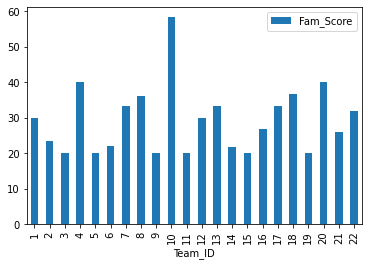

In [ ]:
#Plot familiarity score
familiar = pd.DataFrame(fam_score, team_id)
familiar_mod = familiar.reset_index()
familiar_mod.columns = ['Team_ID', 'Fam_Score']
familiar_mod.plot.bar(x = 'Team_ID', y = 'Fam_Score')

In [ ]:
familiar_array = []
familiarity.loc[1].mean()
for i in range(1,87):
  familiar_array.append(round(familiarity.loc[i].mean(), 2))
familiar_array

[1.0,
 1.33,
 1.67,
 2.0,
 1.33,
 1.0,
 1.0,
 1.33,
 1.0,
 1.0,
 1.0,
 1.0,
 1.67,
 3.0,
 1.67,
 1.67,
 1.0,
 1.0,
 1.0,
 1.0,
 1.25,
 1.0,
 1.25,
 1.0,
 1.0,
 2.0,
 1.0,
 2.0,
 2.0,
 2.0,
 2.0,
 1.5,
 1.5,
 1.0,
 1.0,
 1.0,
 2.67,
 3.0,
 3.0,
 3.0,
 1.0,
 1.0,
 1.0,
 1.0,
 2.0,
 1.5,
 1.67,
 1.67,
 1.67,
 1.67,
 1.33,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.67,
 1.0,
 1.0,
 1.67,
 2.0,
 2.0,
 1.0,
 1.0,
 2.0,
 2.33,
 2.0,
 1.0,
 1.0,
 1.0,
 1.0,
 2.33,
 2.33,
 2.33,
 1.5,
 1.5,
 1.0,
 1.25,
 1.25,
 2.0,
 1.0,
 2.0,
 1.0,
 2.0]

In [ ]:
#Calculating delayed response quotient for all teams
delay_resp = []
for i in range(1,23):
  delay_resp.append(round(response_delay_quo(i),2))

delay_resp

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying t

[0.65,
 0.72,
 0.67,
 0.7,
 0.54,
 0.71,
 0.6,
 0.69,
 0.68,
 0.62,
 0.79,
 0.73,
 0.75,
 0.59,
 0.62,
 0.67,
 0.6,
 0.74,
 0.65,
 0.71,
 0.53,
 0.58]

In [ ]:
#Delayed response quotient for each member
delay_resp_array = []
for i in range(1,23):
  new_frame = TextToDf(i)
  new_frame = new_frame.reset_index()
  new_frame = new_frame.drop(['index'], axis = 1)
  emp_detect = pd.DataFrame(new_frame['time_stamp'])
  emp_detect['person'] = new_frame['person']
  emp_detect['person'] = emp_detect['person'].astype('category')
  emp_detect['time_stamp'] = emp_detect['time_stamp'].astype('float')
  emp_detect['resp_diff'] = emp_detect['resp_delay'] = None

  for i in range(len(emp_detect)-1):
    emp_detect['resp_diff'][i] = emp_detect['time_stamp'][i+1] - emp_detect['time_stamp'][i]
  for i in range(len(emp_detect)-1):
    if emp_detect['resp_diff'][i] > emp_detect['resp_diff'].mean():
      emp_detect['resp_delay'][i] = 1
    else:
      emp_detect['resp_delay'][i] = 0

  delay_mem = emp_detect.groupby(['person', 'resp_delay']).count()
  i = 0
  while i < len(delay_mem):
    delay_resp_array.append(round(delay_mem['resp_diff'][i+1]/delay_mem['resp_diff'][i],2))
    i += 2
delay_resp_array

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying t

[0.71,
 0.88,
 0.53,
 0.43,
 0.66,
 0.75,
 0.9,
 0.62,
 0.6,
 0.8,
 0.55,
 0.64,
 1.02,
 0.72,
 0.6,
 0.5,
 0.38,
 0.52,
 0.76,
 0.26,
 0.78,
 0.43,
 1.07,
 0.36,
 0.85,
 0.81,
 0.56,
 0.38,
 0.87,
 0.48,
 0.91,
 0.42,
 0.81,
 0.76,
 0.57,
 0.71,
 0.5,
 0.61,
 0.69,
 0.71,
 0.89,
 0.65,
 0.79,
 1.11,
 0.67,
 0.5,
 0.82,
 0.61,
 0.92,
 0.36,
 0.41,
 0.56,
 0.88,
 0.4,
 0.37,
 0.85,
 0.5,
 0.85,
 0.67,
 0.84,
 0.66,
 0.53,
 0.58,
 0.59,
 0.63,
 0.39,
 0.65,
 0.98,
 0.83,
 0.76,
 0.37,
 0.72,
 0.78,
 0.41,
 0.73,
 0.74,
 0.48,
 0.7,
 0.52,
 0.5,
 0.35,
 0.59,
 0.57,
 0.36,
 0.6,
 0.81]

In [ ]:
# Text Preprocessing
new_frame = TextToDf(22)
new_frame['line'] = new_frame['line'].astype('str')
new_frame['line'] = new_frame['line'].apply(lambda x: clean_text(x))
new_frame['line'] = new_frame['line'].apply(lambda x: lem(x))
#line = new_frame['line']
new_frame=new_frame.reset_index(drop=True)

uni_per = new_frame['person'].unique()
uni_per = sorted(uni_per)
new_frame


,time_stamp,person,line
0,4.09,person1,[okay]
1,7.29,person1,"[i, guess, we, need, get, start, point, guy, p..."
2,10.28,person3,"[i, put, oxygen]"
3,12.42,person2,[]
4,12.6,person4,[]
...,...,...,...
347,892.01,person5,"[six, okay]"
348,894.85,person2,"[six, we, agree]"
349,896.11,person4,"[yeah, map]"
350,897.32,person1,[okay]


In [ ]:
#empty_line = new_frame['line'][3]
#for i in range(len(new_frame)):
#    if new_frame['line'][i]==empty_line:
#        new_frame=new_frame.drop(i)
#new_frame=new_frame.reset_index(drop=True)
#new_frame

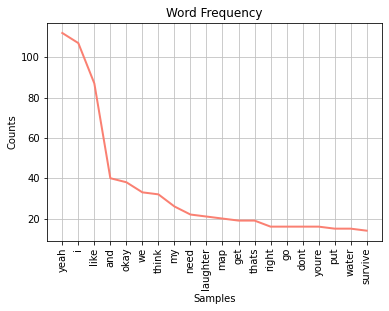

In [ ]:
#Plotting text frequency
#From lists of comments to a single list containing all words      
all_words=[]        
for i in range(len(new_frame)):
    all_words = all_words + new_frame['line'][i]
#Get word frequency        
nlp_words = FreqDist(all_words)
plot1 = nlp_words.plot(20, color='salmon', title='Word Frequency')

In [ ]:
nlp_words['i']

107

In [ ]:
nlp_words['we']

33

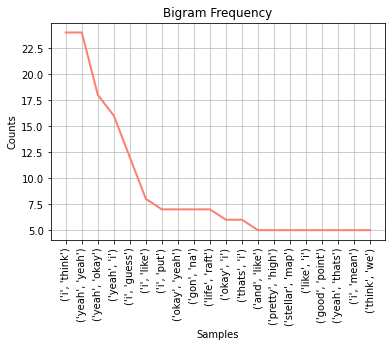

In [ ]:
#Bigrams
bigrm = list(nltk.bigrams(all_words))
words_2 = FreqDist(bigrm)
words_2.plot(20, color='salmon', title='Bigram Frequency')

In [ ]:
words_2[('yeah', 'and')]

1

In [ ]:
words_2[('good', 'point')]

5

(0.0, 300.0)

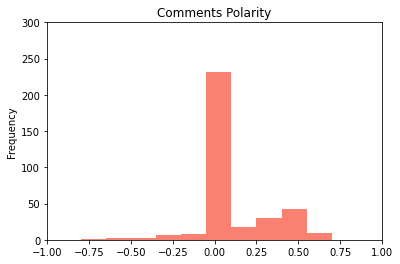

In [ ]:
#Get sentiment from lines - For Teams
new_frame['line'] = [str(thing) for thing in new_frame['line']]
sentiment = []
for i in range(len(new_frame)):
    blob = TextBlob(new_frame['line'][i])
    for sentence in blob.sentences:
        sentiment.append(sentence.sentiment.polarity)
new_frame['sentiment']=sentiment
#Plot
new_frame['sentiment'].plot.hist(color='salmon', title='Comments Polarity')
plt.xlim(-1,1)
plt.ylim(0, 300)

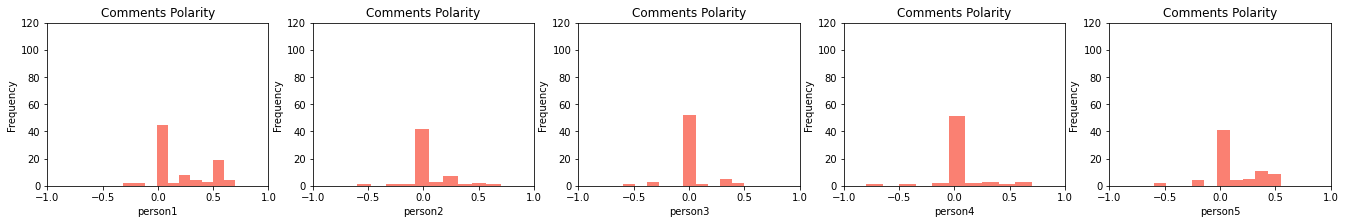

In [ ]:
#Get sentiment from lines - Per team - Unit testing
new_frame['line'] = [str(thing) for thing in new_frame['line']]
fig, axs = plt.subplots(1, len(uni_per), figsize=(23, 3))
for i in range(len(uni_per)):
  result_df = new_frame.loc[new_frame['person'] == uni_per[i]]
  result_df = result_df.reset_index()
  result_df = result_df.drop(['index'], axis = 1)
  sentiment = []
  for j in range(len(result_df)):
    blob = TextBlob(result_df['line'][j])
    for sentence in blob.sentences:
        sentiment.append(sentence.sentiment.polarity)
  result_df['sentiment']=sentiment
  #Plot
  result_df['sentiment'].plot.hist(color='salmon', title='Comments Polarity',ax = axs[i])
  axs[i].set_xlabel(uni_per[i])
  axs[i].set_ylim([0,120])
  axs[i].set_xlim([-1,1])
  

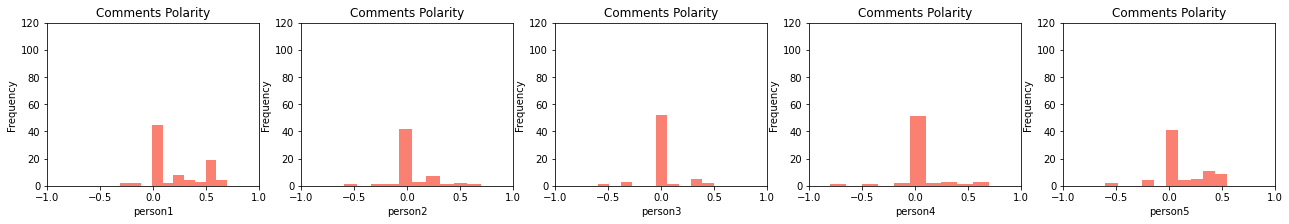

In [ ]:
sentimental_analysis_team(22)

In [ ]:
new_frame = TextToDf(5)
new_frame['line'] = new_frame['line'].astype('str')
new_frame['line'] = new_frame['line'].apply(lambda x: clean_text(x))
new_frame['line'] = new_frame['line'].apply(lambda x: lem(x))
strng = new_frame["line"]
strng = strng.reset_index()
strng = strng.drop(['index'], axis = 1)

con = list()
for i in range(len(strng)):
  con = con + strng['line'][i]

mytext = nltk.Text(con)

mytext

<Text: first we want sort right okay first we...>

In [ ]:
mytext.similar('yeah')

i right one hesitation oppose


In [ ]:
mytext.common_contexts(['yeah', 'okay'])

No common contexts were found


In [ ]:
mytext.collocations()

signal flare; heat unit; make sense; parachute silk; aid kit; dont
know; first aid; life raft; food concentrate; stellar map; receiver
transmitter; take apart; thats good; steller map; detail compare;
fifty foot; fire mechanism; foot nylon; injection needle; melt core


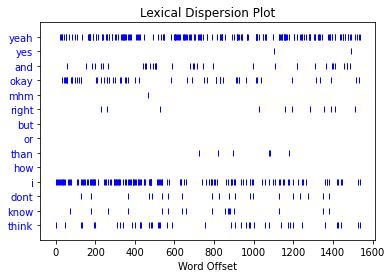

In [ ]:
lexical_dispersion(3)

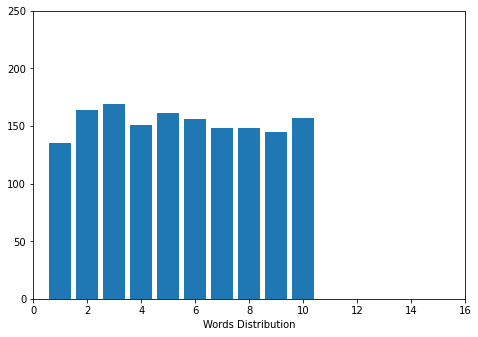

In [ ]:
# Word Distribution
words_dist = words_per_minute(3)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = np.arange(1, len(words_dist)+1)
students = words_dist
ax.bar(langs,students)
plt.xlabel('Words Distribution')
plt.xlim((0, 16))
plt.ylim((0,250))
plt.show()

Text(0.5, 0, 'Words per minute')

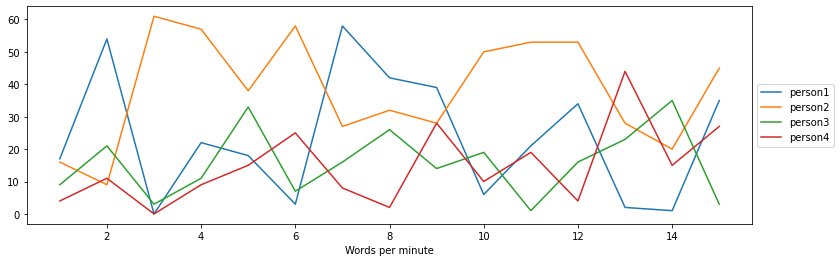

In [ ]:
wr = words_per_person(1)

people = ['person1', 'person2', 'person3', 'person4','person5']
ax = wr.plot.line(figsize=(13,4))
ax.legend(people, loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xlabel('Words per minute')

In [ ]:
# Average words per minute
word_rate = []
for i in range(1, 23):
  word_rate.append(round(np.median(words_per_minute(i)),2))
word_rate

[97.0,
 139.0,
 153.5,
 101.5,
 98.0,
 127.0,
 93.0,
 142.0,
 99.0,
 106.0,
 111.0,
 122.5,
 108.0,
 102.5,
 137.0,
 115.5,
 98.0,
 156.0,
 106.0,
 120.0,
 158.0,
 112.0]

In [ ]:
eng_array = []
for i in range(1,87):
  eng_m_sum = perc_engage.loc[i].sum()
  eng_array.append(round((eng_m_sum/(25))*100,2))
eng_array

[76.0,
 76.0,
 88.0,
 92.0,
 96.0,
 84.0,
 100.0,
 76.0,
 96.0,
 84.0,
 76.0,
 96.0,
 100.0,
 100.0,
 100.0,
 84.0,
 36.0,
 48.0,
 64.0,
 80.0,
 97.18,
 84.0,
 100.0,
 40.0,
 84.0,
 72.0,
 84.0,
 84.0,
 92.0,
 88.0,
 92.0,
 100.0,
 84.0,
 92.0,
 72.0,
 80.0,
 96.0,
 88.0,
 100.0,
 76.0,
 84.0,
 84.0,
 84.0,
 88.0,
 100.0,
 100.0,
 80.0,
 64.0,
 92.0,
 76.0,
 92.0,
 92.0,
 92.0,
 96.0,
 96.0,
 92.0,
 100.0,
 100.0,
 92.0,
 92.0,
 96.0,
 96.0,
 76.0,
 84.0,
 68.0,
 92.0,
 92.0,
 92.0,
 80.0,
 92.0,
 68.0,
 68.0,
 96.0,
 60.0,
 100.0,
 92.0,
 76.0,
 100.0,
 80.0,
 88.0,
 80.0,
 92.0,
 88.0,
 88.0,
 100.0,
 88.0]

In [ ]:
#Calculating median word rate per minute for all team members
word_rate_array = []
for i in range(1,23):
  wr = words_per_person(i)
  word_rate_array.append(list(wr.median()))
word_rate_array = [j for i in word_rate_array for j in i]
word_rate_array

[21.0,
 38.0,
 16.0,
 11.0,
 39.0,
 37.5,
 25.0,
 30.0,
 36.0,
 51.5,
 19.0,
 36.5,
 23.0,
 14.0,
 48.0,
 6.0,
 17.0,
 16.0,
 55.0,
 11.0,
 47.0,
 21.0,
 28.5,
 2.5,
 9.5,
 37.0,
 24.5,
 27.0,
 25.0,
 26.0,
 36.0,
 28.0,
 26.0,
 18.0,
 20.5,
 55.0,
 19.0,
 40.0,
 20.0,
 23.0,
 48.0,
 24.5,
 40.5,
 38.5,
 47.5,
 34.0,
 45.0,
 24.0,
 36.0,
 1.0,
 20.5,
 14.0,
 53.0,
 13.5,
 21.0,
 54.0,
 20.5,
 21.5,
 20.5,
 18.0,
 46.0,
 25.0,
 31.5,
 14.5,
 54.0,
 14.0,
 36.0,
 28.0,
 71.0,
 59.0,
 15.0,
 38.0,
 45.0,
 4.0,
 24.0,
 44.0,
 23.0,
 62.0,
 47.0,
 23.0,
 8.0,
 31.5,
 10.0,
 13.5,
 17.0,
 30.0]

In [ ]:
emp_lead = []

for i in range(1,23):
  # Text Preprocessing
  new_frame = TextToDf(i)
  new_frame['line'] = new_frame['line'].astype('str')
  new_frame['line'] = new_frame['line'].apply(lambda x: clean_text(x))
  new_frame['line'] = new_frame['line'].apply(lambda x: lem(x))
  #line = new_frame['line']
  new_frame=new_frame.reset_index(drop=True)

  all_words=[]
  for j in range(len(new_frame)):
    all_words = all_words + new_frame['line'][j]
  #Get word frequency        
  nlp_words = FreqDist(all_words)
  i_count = nlp_words['i']
  we_count = nlp_words['we']
  emp_lead.append(round(we_count/i_count, 2))

emp_lead

[0.27,
 0.17,
 0.4,
 0.55,
 0.29,
 0.73,
 0.44,
 0.62,
 0.47,
 1.07,
 0.29,
 0.26,
 0.4,
 0.27,
 0.24,
 0.67,
 0.49,
 0.91,
 0.5,
 0.56,
 0.63,
 0.31]

In [ ]:
emp_lead_per = []
all_words_line=[]
person = ['person1', 'person2', 'person3', 'person4', 'person5']

for k in range(1,23):
  # Text Preprocessing
  new_frame = TextToDf(k)
  new_frame['line'] = new_frame['line'].astype('str')
  new_frame['line'] = new_frame['line'].apply(lambda x: clean_text(x))
  new_frame['line'] = new_frame['line'].apply(lambda x: lem(x))
  new_frame=new_frame.reset_index(drop=True)

  #Run through each team
  for i in range(len(new_frame['person'].unique())):
    each_pdf = new_frame[new_frame['person'] == person[i]]
    each_pdf = each_pdf.reset_index(drop=True)
    all_words_line.clear()
    for j in range(len(each_pdf)):
      all_words_line += each_pdf['line'][j]
    
    #Get word frequency        
    nlp_words = FreqDist(all_words_line)
    i_count = nlp_words['i']
    we_count = nlp_words['we']

    emp_lead_per.append(round(we_count/i_count, 2))

emp_lead_per

[0.23,
 0.38,
 0.2,
 0.12,
 0.31,
 0.24,
 0.07,
 0.05,
 0.31,
 0.52,
 0.14,
 0.55,
 0.75,
 0.42,
 0.56,
 0.4,
 0.91,
 0.11,
 0.31,
 0.14,
 0.68,
 0.86,
 0.96,
 0.0,
 0.25,
 0.48,
 0.17,
 1.06,
 0.4,
 0.41,
 0.45,
 1.14,
 0.86,
 3.5,
 0.69,
 0.22,
 1.25,
 0.63,
 1.14,
 2.17,
 0.28,
 0.0,
 0.71,
 0.07,
 0.4,
 0.42,
 0.3,
 0.6,
 0.42,
 0.25,
 0.12,
 0.42,
 0.25,
 0.42,
 0.25,
 0.21,
 0.17,
 0.43,
 0.45,
 0.6,
 0.6,
 1.1,
 0.35,
 0.73,
 0.52,
 0.27,
 0.95,
 1.5,
 1.0,
 0.41,
 0.83,
 0.66,
 0.33,
 0.0,
 0.71,
 1.16,
 0.17,
 0.58,
 1.06,
 0.72,
 2.67,
 0.39,
 0.04,
 0.15,
 0.62,
 0.32]

In [ ]:
appr_apol = []

for i in range(1,23):
  # Text Preprocessing
  new_frame = TextToDf(i)
  new_frame['line'] = new_frame['line'].astype('str')
  new_frame['line'] = new_frame['line'].apply(lambda x: clean_text(x))
  new_frame['line'] = new_frame['line'].apply(lambda x: lem(x))
  #line = new_frame['line']
  new_frame=new_frame.reset_index(drop=True)

  all_words=[]
  for j in range(len(new_frame)):
    all_words = all_words + new_frame['line'][j]
  #Get word frequency        
  nlp_words = FreqDist(all_words)
  apol = nlp_words['sorry']
  #Bigrams
  bigrm = list(nltk.bigrams(all_words))
  words_2 = FreqDist(bigrm)
  appr = words_2[('good', 'point')]
  appr_apol.append(apol + appr)

appr_apol


[0, 6, 1, 2, 4, 1, 2, 4, 2, 0, 0, 0, 0, 0, 1, 3, 0, 1, 2, 1, 1, 6]

In [ ]:
#Entire Script
all_words=[]

for i in range(1,23):
  # Text Preprocessing
  new_frame = TextToDf(i)
  new_frame['line'] = new_frame['line'].astype('str')
  new_frame['line'] = new_frame['line'].apply(lambda x: clean_text(x))
  new_frame['line'] = new_frame['line'].apply(lambda x: lem(x))
  #line = new_frame['line']
  new_frame=new_frame.reset_index(drop=True)

  for j in range(len(new_frame)):
    all_words = all_words + new_frame['line'][j]

In [ ]:
idf_nlp_words = FreqDist(all_words)
#freq across corpus
idf_apol = idf_nlp_words['sorry']

idf_bigrm = list(nltk.bigrams(all_words))
idf_words_2 = FreqDist(idf_bigrm)
idf_appr = idf_words_2[('good', 'point')]

In [ ]:
idf_appr_apol = idf_apol+idf_appr

In [ ]:
# Considerate tfidf for teams
tfidf_appr_apol_team = [0]*len(appr_apol)
for i in range(len(appr_apol)):
  tfidf_appr_apol_team[i] = round(appr_apol[i]/idf_appr_apol,5)
tfidf_appr_apol_team

[0.0,
 0.16216,
 0.02703,
 0.05405,
 0.10811,
 0.02703,
 0.05405,
 0.10811,
 0.05405,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.02703,
 0.08108,
 0.0,
 0.02703,
 0.05405,
 0.02703,
 0.02703,
 0.16216]

In [ ]:
appr_apol_line = []
all_words_line=[]
person = ['person1', 'person2', 'person3', 'person4', 'person5']

for k in range(1,23):
  # Text Preprocessing
  new_frame = TextToDf(k)
  new_frame['line'] = new_frame['line'].astype('str')
  new_frame['line'] = new_frame['line'].apply(lambda x: clean_text(x))
  new_frame['line'] = new_frame['line'].apply(lambda x: lem(x))
  new_frame=new_frame.reset_index(drop=True)

  #Run through each team
  for i in range(len(new_frame['person'].unique())):
    each_pdf = new_frame[new_frame['person'] == person[i]]
    each_pdf = each_pdf.reset_index(drop=True)
    all_words_line.clear()
    for j in range(len(each_pdf)):
      all_words_line += each_pdf['line'][j]
    
    #Get word frequency        
    nlp_words = FreqDist(all_words_line)
    apol = nlp_words['sorry']
    #Bigrams
    bigrm = list(nltk.bigrams(all_words_line))
    words_2 = FreqDist(bigrm)
    appr = words_2[('good', 'point')]
    appr_apol_line.append(apol + appr)

len(appr_apol_line)

86

In [ ]:
tfidf_appr_apol = [0]*len(appr_apol_line)
for i in range(len(appr_apol_line)):
  tfidf_appr_apol[i] = round(appr_apol_line[i]/idf_appr_apol,5)
tfidf_appr_apol

[0.0,
 0.0,
 0.0,
 0.0,
 0.10811,
 0.02703,
 0.0,
 0.02703,
 0.0,
 0.02703,
 0.0,
 0.0,
 0.0,
 0.0,
 0.05405,
 0.0,
 0.0,
 0.0,
 0.10811,
 0.0,
 0.02703,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.02703,
 0.02703,
 0.0,
 0.0,
 0.02703,
 0.08108,
 0.0,
 0.02703,
 0.02703,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.02703,
 0.0,
 0.0,
 0.0,
 0.02703,
 0.02703,
 0.02703,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.02703,
 0.02703,
 0.0,
 0.02703,
 0.02703,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.02703,
 0.0,
 0.0,
 0.13514,
 0.02703,
 0.0,
 0.0,
 0.0]

In [ ]:
conv_flow = []

for i in range(1,23):
  # Text Preprocessing
  new_frame = TextToDf(i)
  new_frame['line'] = new_frame['line'].astype('str')
  new_frame['line'] = new_frame['line'].apply(lambda x: clean_text(x))
  new_frame['line'] = new_frame['line'].apply(lambda x: lem(x))
  #line = new_frame['line']
  new_frame=new_frame.reset_index(drop=True)

  all_words=[]
  for j in range(len(new_frame)):
    all_words = all_words + new_frame['line'][j]
  #Bigrams
  bigrm = list(nltk.bigrams(all_words))
  words_2 = FreqDist(bigrm)
  conv_flow.append(words_2[('yeah', 'and')])

conv_flow

[8, 4, 4, 4, 0, 0, 4, 0, 3, 3, 0, 3, 3, 4, 5, 3, 2, 3, 2, 6, 5, 1]

In [ ]:
idf_conv_flow = idf_words_2[('yeah', 'and')]
idf_conv_flow

67

In [ ]:
tfidf_conv_flow_team = [0]*len(conv_flow)
for i in range(len(conv_flow)):
  tfidf_conv_flow_team[i] = round(conv_flow[i]/idf_conv_flow,5)
tfidf_conv_flow_team

[0.1194,
 0.0597,
 0.0597,
 0.0597,
 0.0,
 0.0,
 0.0597,
 0.0,
 0.04478,
 0.04478,
 0.0,
 0.04478,
 0.04478,
 0.0597,
 0.07463,
 0.04478,
 0.02985,
 0.04478,
 0.02985,
 0.08955,
 0.07463,
 0.01493]

In [ ]:
conv_flow_line = []
all_words_line=[]
person = ['person1', 'person2', 'person3', 'person4', 'person5']

for k in range(1,23):
  # Text Preprocessing
  new_frame = TextToDf(k)
  new_frame['line'] = new_frame['line'].astype('str')
  new_frame['line'] = new_frame['line'].apply(lambda x: clean_text(x))
  new_frame['line'] = new_frame['line'].apply(lambda x: lem(x))
  new_frame=new_frame.reset_index(drop=True)

  #Run through each team
  for i in range(len(new_frame['person'].unique())):
    each_pdf = new_frame[new_frame['person'] == person[i]]
    each_pdf = each_pdf.reset_index(drop=True)
    all_words_line.clear()
    for j in range(len(each_pdf)):
      all_words_line += each_pdf['line'][j]
    
    #Bigrams
    bigrm = list(nltk.bigrams(all_words_line))
    words_2 = FreqDist(bigrm)
    flow_word = words_2[('yeah', 'and')]
    conv_flow_line.append(flow_word)

conv_flow_line

[2,
 5,
 1,
 0,
 0,
 2,
 1,
 1,
 0,
 3,
 0,
 2,
 0,
 3,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 5,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 2,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 3,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 2,
 2,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 2,
 1,
 0,
 2,
 1,
 0,
 3,
 1,
 0,
 1,
 2,
 1,
 0,
 1,
 0,
 0,
 0,
 0]

In [ ]:
tfidf_conv_flow_per = [0]*len(conv_flow_line)
for i in range(len(conv_flow_line)):
  tfidf_conv_flow_per[i] = round(conv_flow_line[i]/idf_conv_flow,5)
tfidf_conv_flow_per

[0.02985,
 0.07463,
 0.01493,
 0.0,
 0.0,
 0.02985,
 0.01493,
 0.01493,
 0.0,
 0.04478,
 0.0,
 0.02985,
 0.0,
 0.04478,
 0.02985,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.07463,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.01493,
 0.01493,
 0.02985,
 0.0,
 0.01493,
 0.0,
 0.01493,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.01493,
 0.04478,
 0.0,
 0.01493,
 0.0,
 0.0,
 0.0,
 0.01493,
 0.0,
 0.01493,
 0.0,
 0.0,
 0.02985,
 0.02985,
 0.01493,
 0.01493,
 0.0,
 0.01493,
 0.01493,
 0.01493,
 0.0,
 0.01493,
 0.0,
 0.0,
 0.0,
 0.02985,
 0.01493,
 0.0,
 0.02985,
 0.01493,
 0.0,
 0.04478,
 0.01493,
 0.0,
 0.01493,
 0.02985,
 0.01493,
 0.0,
 0.01493,
 0.0,
 0.0,
 0.0,
 0.0]

In [ ]:
#Attentive listening Index based on text count - 'yeah', 'yes', 'okay', 'uhmm', 'hmm', 'uhm'
listen_freq = []
lis = ['yeah', 'yes', 'okay', 'hmm', 'uhm']
for i in range(1, 23):
  frame = TextToDf(i)
  listen_freq.append(tf(frame, lis))
listen_freq

[122,
 160,
 248,
 131,
 57,
 72,
 152,
 181,
 82,
 62,
 94,
 177,
 111,
 25,
 18,
 23,
 15,
 22,
 11,
 6,
 14,
 27]

In [ ]:
#Entire Script
all_words=[]

for i in range(1,23):
  # Text Preprocessing
  new_frame = TextToDf(i)
  new_frame['line'] = new_frame['line'].astype('str')
  new_frame['line'] = new_frame['line'].apply(lambda x: clean_text(x))
  new_frame['line'] = new_frame['line'].apply(lambda x: lem(x))
  #line = new_frame['line']
  new_frame=new_frame.reset_index(drop=True)

  for j in range(len(new_frame)):
    all_words = all_words + new_frame['line'][j]

nlp_words = FreqDist(all_words)
idf_lis_freq = 0
#Get word frequency    
for j in lis:
  idf_lis_freq += nlp_words[j]

idf_lis_freq

2817

In [ ]:
tfidf_lis_freq_team = [0]*len(listen_freq)
for i in range(len(listen_freq)):
  tfidf_lis_freq_team[i] = round(listen_freq[i]/idf_lis_freq,5)
tfidf_lis_freq_team

[0.04331,
 0.0568,
 0.08804,
 0.0465,
 0.02023,
 0.02556,
 0.05396,
 0.06425,
 0.02911,
 0.02201,
 0.03337,
 0.06283,
 0.0394,
 0.00887,
 0.00639,
 0.00816,
 0.00532,
 0.00781,
 0.0039,
 0.00213,
 0.00497,
 0.00958]

In [ ]:
attn_listen_per = []
all_words_line=[]
person = ['person1', 'person2', 'person3', 'person4', 'person5']

for k in range(1,23):
  # Text Preprocessing
  new_frame = TextToDf(k)
  new_frame['line'] = new_frame['line'].astype('str')
  new_frame['line'] = new_frame['line'].apply(lambda x: clean_text(x))
  new_frame['line'] = new_frame['line'].apply(lambda x: lem(x))
  new_frame=new_frame.reset_index(drop=True)

  #Run through each team
  for i in range(len(new_frame['person'].unique())):
    each_pdf = new_frame[new_frame['person'] == person[i]]
    each_pdf = each_pdf.reset_index(drop=True)
    all_words_line.clear()
    for j in range(len(each_pdf)):
      all_words_line += each_pdf['line'][j]

    #Get word frequency        
    nlp_words = FreqDist(all_words_line)

    count = 0
    for ch in lis:
      count += nlp_words[ch]
    attn_listen_per.append(count)

attn_listen_per


[39,
 28,
 25,
 30,
 49,
 33,
 50,
 40,
 40,
 122,
 24,
 62,
 13,
 22,
 83,
 13,
 7,
 7,
 36,
 7,
 26,
 26,
 3,
 12,
 5,
 89,
 26,
 38,
 48,
 56,
 26,
 24,
 27,
 19,
 12,
 51,
 15,
 16,
 15,
 16,
 31,
 37,
 26,
 40,
 109,
 28,
 56,
 22,
 31,
 2,
 30,
 12,
 54,
 8,
 36,
 21,
 48,
 36,
 52,
 35,
 66,
 14,
 46,
 19,
 20,
 14,
 37,
 37,
 32,
 56,
 34,
 18,
 51,
 8,
 31,
 43,
 16,
 36,
 65,
 24,
 6,
 47,
 23,
 30,
 19,
 31]

In [ ]:
tfidf_lis_freq_per = [0]*len(attn_listen_per)
for i in range(len(attn_listen_per)):
  tfidf_lis_freq_per[i] = round(attn_listen_per[i]/idf_lis_freq,5)
tfidf_lis_freq_per

[0.01384,
 0.00994,
 0.00887,
 0.01065,
 0.01739,
 0.01171,
 0.01775,
 0.0142,
 0.0142,
 0.04331,
 0.00852,
 0.02201,
 0.00461,
 0.00781,
 0.02946,
 0.00461,
 0.00248,
 0.00248,
 0.01278,
 0.00248,
 0.00923,
 0.00923,
 0.00106,
 0.00426,
 0.00177,
 0.03159,
 0.00923,
 0.01349,
 0.01704,
 0.01988,
 0.00923,
 0.00852,
 0.00958,
 0.00674,
 0.00426,
 0.0181,
 0.00532,
 0.00568,
 0.00532,
 0.00568,
 0.011,
 0.01313,
 0.00923,
 0.0142,
 0.03869,
 0.00994,
 0.01988,
 0.00781,
 0.011,
 0.00071,
 0.01065,
 0.00426,
 0.01917,
 0.00284,
 0.01278,
 0.00745,
 0.01704,
 0.01278,
 0.01846,
 0.01242,
 0.02343,
 0.00497,
 0.01633,
 0.00674,
 0.0071,
 0.00497,
 0.01313,
 0.01313,
 0.01136,
 0.01988,
 0.01207,
 0.00639,
 0.0181,
 0.00284,
 0.011,
 0.01526,
 0.00568,
 0.01278,
 0.02307,
 0.00852,
 0.00213,
 0.01668,
 0.00816,
 0.01065,
 0.00674,
 0.011]

In [ ]:
#Diversified Opinions Index based on text count - 'or', 'than'
or_freq = []
div = ['or', 'than', 'but']
for i in range(1, 23):
  frame = TextToDf(i)
  or_freq.append(tf(frame, div))
or_freq

[45,
 56,
 43,
 25,
 39,
 49,
 27,
 35,
 44,
 19,
 16,
 27,
 43,
 38,
 19,
 32,
 36,
 29,
 37,
 35,
 75,
 34]

In [ ]:
#Entire Script
all_words=[]

for i in range(1,23):
  # Text Preprocessing
  new_frame = TextToDf(i)
  new_frame['line'] = new_frame['line'].astype('str')
  new_frame['line'] = new_frame['line'].apply(lambda x: clean_text(x))
  new_frame['line'] = new_frame['line'].apply(lambda x: lem(x))
  #line = new_frame['line']
  new_frame=new_frame.reset_index(drop=True)

  for j in range(len(new_frame)):
    all_words = all_words + new_frame['line'][j]

nlp_words = FreqDist(all_words)
idf_div_op = 0
#Get word frequency    
for j in div:
  idf_div_op += nlp_words[j]

idf_div_op

853

In [ ]:
tfidf_or_freq_team = [0]*len(or_freq)
for i in range(len(or_freq)):
  tfidf_or_freq_team[i] = round(or_freq[i]/idf_div_op,5)
tfidf_or_freq_team

[0.05275,
 0.06565,
 0.05041,
 0.02931,
 0.04572,
 0.05744,
 0.03165,
 0.04103,
 0.05158,
 0.02227,
 0.01876,
 0.03165,
 0.05041,
 0.04455,
 0.02227,
 0.03751,
 0.0422,
 0.034,
 0.04338,
 0.04103,
 0.08792,
 0.03986]

In [ ]:
div_opinion_per = []
all_words_line=[]
person = ['person1', 'person2', 'person3', 'person4', 'person5']

for k in range(1,23):
  # Text Preprocessing
  new_frame = TextToDf(k)
  new_frame['line'] = new_frame['line'].astype('str')
  new_frame['line'] = new_frame['line'].apply(lambda x: clean_text(x))
  new_frame['line'] = new_frame['line'].apply(lambda x: lem(x))
  new_frame=new_frame.reset_index(drop=True)

  #Run through each team
  for i in range(len(new_frame['person'].unique())):
    each_pdf = new_frame[new_frame['person'] == person[i]]
    each_pdf = each_pdf.reset_index(drop=True)
    all_words_line.clear()
    for j in range(len(each_pdf)):
      all_words_line += each_pdf['line'][j]

    #Get word frequency        
    nlp_words = FreqDist(all_words_line)

    count = 0
    for ch in div:
      count += nlp_words[ch]
    div_opinion_per.append(count)

div_opinion_per


[0,
 3,
 2,
 2,
 3,
 4,
 1,
 3,
 2,
 1,
 0,
 3,
 0,
 1,
 1,
 0,
 2,
 1,
 3,
 1,
 7,
 1,
 0,
 0,
 0,
 1,
 2,
 0,
 0,
 2,
 0,
 2,
 1,
 0,
 1,
 6,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 2,
 3,
 1,
 1,
 0,
 0,
 3,
 2,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 2,
 0,
 2,
 2,
 4,
 1,
 2,
 0,
 5,
 2,
 0,
 4,
 3,
 0,
 2,
 0,
 6,
 2,
 1,
 6,
 0,
 0,
 2,
 1,
 0,
 2]

In [ ]:
tfidf_div_op_per = [0]*len(div_opinion_per)
for i in range(len(div_opinion_per)):
  tfidf_div_op_per[i] = round(div_opinion_per[i]/idf_div_op,5)
tfidf_div_op_per

[0.0,
 0.00352,
 0.00234,
 0.00234,
 0.00352,
 0.00469,
 0.00117,
 0.00352,
 0.00234,
 0.00117,
 0.0,
 0.00352,
 0.0,
 0.00117,
 0.00117,
 0.0,
 0.00234,
 0.00117,
 0.00352,
 0.00117,
 0.00821,
 0.00117,
 0.0,
 0.0,
 0.0,
 0.00117,
 0.00234,
 0.0,
 0.0,
 0.00234,
 0.0,
 0.00234,
 0.00117,
 0.0,
 0.00117,
 0.00703,
 0.0,
 0.00117,
 0.0,
 0.0,
 0.00117,
 0.0,
 0.0,
 0.00117,
 0.0,
 0.00234,
 0.00352,
 0.00117,
 0.00117,
 0.0,
 0.0,
 0.00352,
 0.00234,
 0.00117,
 0.0,
 0.0,
 0.00117,
 0.0,
 0.00117,
 0.00117,
 0.00234,
 0.0,
 0.00234,
 0.00234,
 0.00469,
 0.00117,
 0.00234,
 0.0,
 0.00586,
 0.00234,
 0.0,
 0.00469,
 0.00352,
 0.0,
 0.00234,
 0.0,
 0.00703,
 0.00234,
 0.00117,
 0.00703,
 0.0,
 0.0,
 0.00234,
 0.00117,
 0.0,
 0.00234]

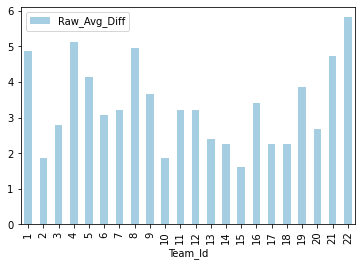

In [ ]:
#Plotting Team Performance based on Rank Scores
Team_Score = pd.read_csv("Group_Rank_Scores.csv")
Team_Score.plot.bar(x='Team_Id', y='Raw_Avg_Diff', colormap = 'Paired')

In [ ]:
diverse_op = pd.DataFrame(or_freq, team_id)
diverse_op_mod = diverse_op.reset_index()
diverse_op_mod.columns = ['Team_ID', 'Div_Opinion']
diverse_op_mod['Att_Listen'] = listen_freq
diverse_op_mod['Size'] = size
diverse_op_mod['Familiar'] = familiar_mod['Fam_Score']
diverse_op_mod['Eng_Score'] = engage_score
diverse_op_mod['Knowledge'] = team_know
diverse_op_mod['Skill'] = team_skill
diverse_op_mod['Male_Frac'] = gender_frac
diverse_op_mod['Emp_Lead'] = emp_lead
diverse_op_mod['Appr_Apol'] = appr_apol
diverse_op_mod['Conv_Flow'] = conv_flow
diverse_op_mod['Word_Rate'] = word_rate
diverse_op_mod['Eq_Par'] = eq_par
diverse_op_mod['Delay_Resp'] = delay_resp
diverse_op_mod['Diversity'] = diversity
diverse_op_mod['Team_Score'] = round(Team_Score['Raw_Avg_Diff'],2)

diverse_op_mod

,Team_ID,Div_Opinion,Att_Listen,Size,Familiar,Eng_Score,Knowledge,Skill,Male_Frac,Emp_Lead,Appr_Apol,Conv_Flow,Word_Rate,Eq_Par,Delay_Resp,Diversity,Team_Score
0,1,45,122,4,30.00,83.00,55.00,0.0,75.00,0.27,0,8,97.0,1439.14,0.65,0.75,4.87
1,2,56,160,4,23.33,89.00,45.00,50.0,50.00,0.17,6,4,139.0,525.21,0.72,0.75,1.87
2,3,43,248,4,20.00,88.00,25.00,0.0,100.00,0.40,1,4,153.5,986.33,0.67,0.50,2.80
3,4,25,131,4,40.00,96.00,55.00,25.0,75.00,0.55,2,4,101.5,1678.90,0.70,0.75,5.13
4,5,39,57,4,20.00,57.00,50.00,50.0,100.00,0.29,4,0,98.0,2609.17,0.54,0.75,4.13
5,6,49,72,5,22.00,81.04,56.00,80.0,0.00,0.73,1,0,127.0,1845.21,0.71,0.50,3.07
6,7,27,152,3,33.33,80.00,33.33,0.0,0.00,0.44,2,4,93.0,878.35,0.60,0.25,3.20
7,8,35,181,5,36.00,91.20,40.00,20.0,80.00,0.62,4,0,142.0,572.90,0.69,0.75,4.96
8,9,44,82,3,20.00,81.33,33.33,0.0,66.67,0.47,2,3,99.0,2430.31,0.68,0.50,3.67
9,10,19,62,4,58.33,90.00,70.00,0.0,50.00,1.07,0,3,106.0,1236.32,0.62,0.25,1.85


In [ ]:
#Combining features ####################################################
diverse = diverse_op_mod.copy()
exp = minmax_scaling(diverse, columns=['Div_Opinion', 'Att_Listen', 'Familiar', 'Eng_Score', 'Knowledge', 'Skill', 'Male_Frac', 'Emp_Lead', 'Appr_Apol', 'Conv_Flow', 'Word_Rate', 'Size', 'Eq_Par', 'Delay_Resp', 'Diversity'])
#exp['Team_ID'] = diverse['Team_ID']
exp['Team_Score'] = diverse['Team_Score']
#exp['Size'] = diverse['Size']
exp.index = np.arange(1, len(exp) + 1)

exp
#diverse


,Div_Opinion,Att_Listen,Familiar,Eng_Score,Knowledge,Skill,Male_Frac,Emp_Lead,Appr_Apol,Conv_Flow,Word_Rate,Size,Eq_Par,Delay_Resp,Diversity,Team_Score
1,0.491525,0.479339,0.260892,0.65000,0.666667,0.0000,0.7500,0.111111,0.000000,1.000,0.061538,0.5,0.409162,0.461538,1.0,4.87
2,0.677966,0.636364,0.086877,0.80000,0.444444,0.6250,0.5000,0.000000,1.000000,0.500,0.707692,0.5,0.058040,0.730769,1.0,1.87
3,0.457627,1.000000,0.000000,0.77500,0.000000,0.0000,1.0000,0.255556,0.166667,0.500,0.930769,0.5,0.235197,0.538462,0.5,2.80
4,0.152542,0.516529,0.521785,0.97500,0.666667,0.3125,0.7500,0.422222,0.333333,0.500,0.130769,0.5,0.501276,0.653846,1.0,5.13
5,0.389831,0.210744,0.000000,0.00000,0.555556,0.6250,1.0000,0.133333,0.666667,0.000,0.076923,0.5,0.858676,0.038462,1.0,4.13
6,0.559322,0.272727,0.052178,0.60100,0.688889,1.0000,0.0000,0.622222,0.166667,0.000,0.523077,1.0,0.565170,0.692308,0.5,3.07
7,0.186441,0.603306,0.347769,0.57500,0.185111,0.0000,0.0000,0.300000,0.333333,0.500,0.000000,0.0,0.193712,0.269231,0.0,3.20
8,0.322034,0.723140,0.417428,0.85500,0.333333,0.2500,0.8000,0.500000,0.666667,0.000,0.753846,1.0,0.076362,0.615385,1.0,4.96
9,0.474576,0.314050,0.000000,0.60825,0.185111,0.0000,0.6667,0.333333,0.333333,0.375,0.092308,0.0,0.789960,0.576923,0.5,3.67
10,0.050847,0.231405,1.000000,0.82500,1.000000,0.0000,0.5000,1.000000,0.000000,0.375,0.200000,0.5,0.331241,0.346154,0.0,1.85


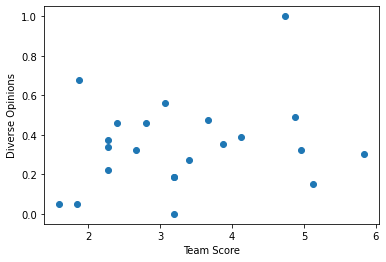

In [ ]:
plt.scatter('Team_Score', 'Div_Opinion', data=exp)
plt.xlabel("Team Score")
plt.ylabel("Diverse Opinions")
plt.show()

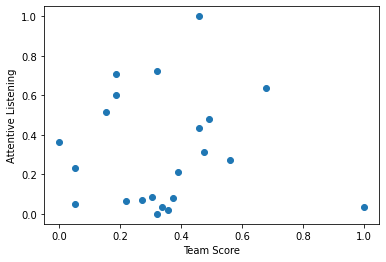

In [ ]:
plt.scatter('Div_Opinion', 'Att_Listen', data=exp)
plt.xlabel("Team Score")
plt.ylabel("Attentive Listening")
plt.show()

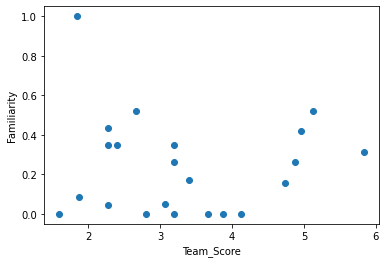

In [ ]:
plt.scatter('Team_Score', 'Familiar', data=exp)
plt.xlabel("Team_Score")
plt.ylabel("Familiarity")
plt.show()

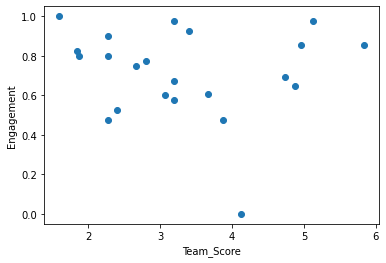

In [ ]:
plt.scatter('Team_Score', 'Eng_Score', data=exp)
plt.xlabel("Team_Score")
plt.ylabel("Engagement")
plt.show()

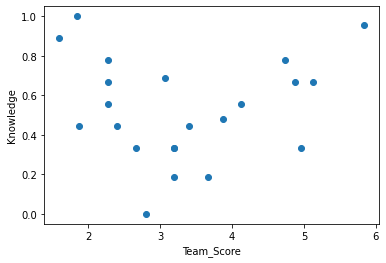

In [ ]:
plt.scatter('Team_Score', 'Knowledge', data=exp)
plt.xlabel("Team_Score")
plt.ylabel("Knowledge")
plt.show()

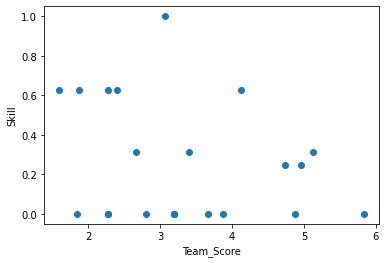

In [ ]:
plt.scatter('Team_Score', 'Skill', data=exp)
plt.xlabel("Team_Score")
plt.ylabel("Skill")
plt.show()

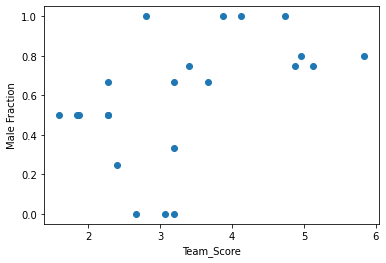

In [ ]:
plt.scatter('Team_Score', 'Male_Frac', data=exp)
plt.xlabel("Team_Score")
plt.ylabel("Male Fraction")
plt.show()

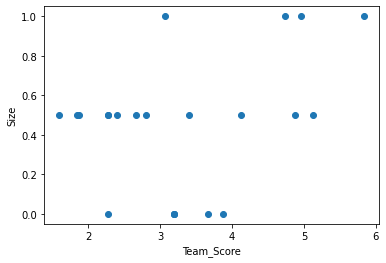

In [ ]:
plt.scatter('Team_Score', 'Size', data=exp)
plt.xlabel("Team_Score")
plt.ylabel("Size")
plt.show()

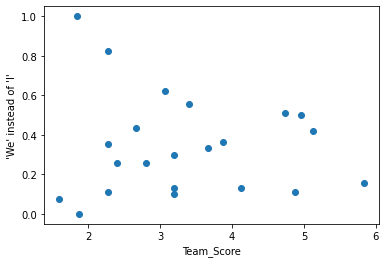

In [ ]:
plt.scatter('Team_Score', 'Emp_Lead', data=exp)
plt.xlabel("Team_Score")
plt.ylabel("'We' instead of 'I'")
plt.show()

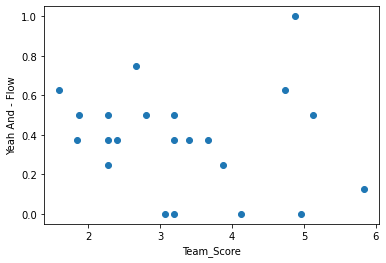

In [ ]:
plt.scatter('Team_Score', 'Conv_Flow', data=exp)
plt.xlabel("Team_Score")
plt.ylabel("Yeah And - Flow")
plt.show()

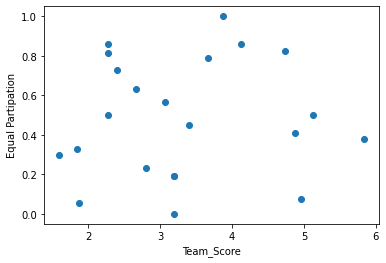

In [ ]:
plt.scatter('Team_Score', 'Eq_Par', data=exp)
plt.xlabel("Team_Score")
plt.ylabel("Equal Partipation")
plt.show()

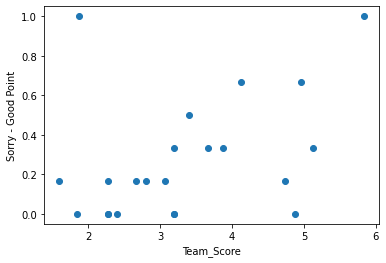

In [ ]:
plt.scatter('Team_Score', 'Appr_Apol', data=exp)
plt.xlabel("Team_Score")
plt.ylabel("Sorry - Good Point")
plt.show()

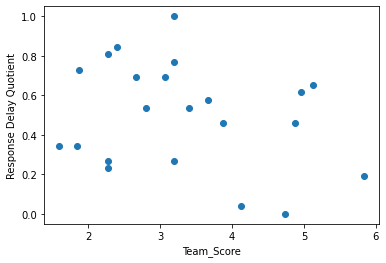

In [ ]:
plt.scatter('Team_Score', 'Delay_Resp', data=exp)
plt.xlabel("Team_Score")
plt.ylabel("Response Delay Quotient")
plt.show()

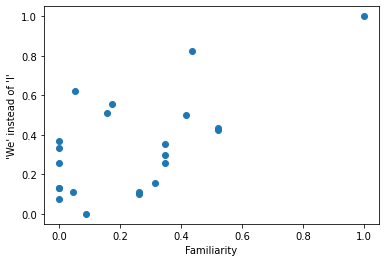

In [ ]:
plt.scatter('Familiar', 'Emp_Lead', data=exp)
plt.xlabel("Familiarity")
plt.ylabel("'We' instead of 'I'")
plt.show()

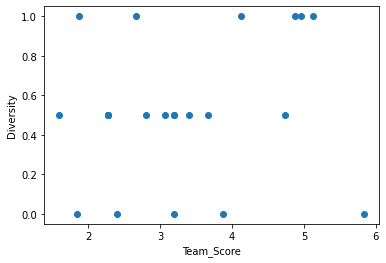

In [ ]:
plt.scatter('Team_Score', 'Diversity', data=exp)
plt.xlabel("Team_Score")
plt.ylabel("Diversity")
plt.show()

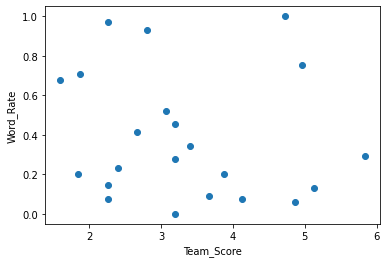

In [ ]:
plt.scatter('Team_Score', 'Word_Rate', data=exp)
plt.xlabel("Team_Score")
plt.ylabel("Word_Rate")
plt.show()

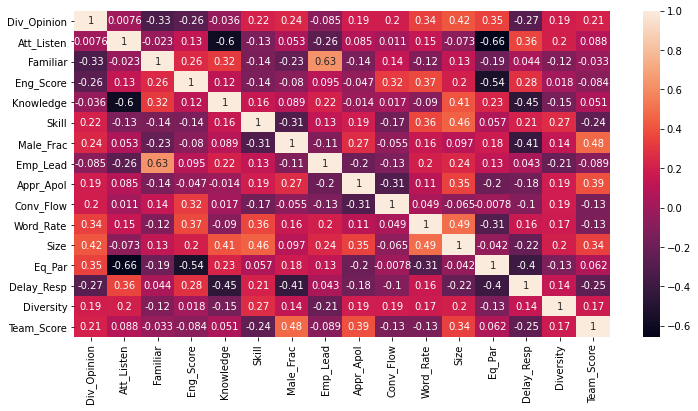

In [ ]:
#exp.corr()
plt.figure(figsize = (12,6))

ax = sns.heatmap(exp.corr(), annot=True)

In [ ]:
# DataFrame with tfIdf score
tfidf_DF = pd.DataFrame(tfidf_or_freq_team, team_id)
tfidf_DF_mod = tfidf_DF.reset_index()
tfidf_DF_mod.columns = ['Team_ID', 'Div_Opinion']
tfidf_DF_mod['Att_Listen'] = tfidf_lis_freq_team
tfidf_DF_mod['Size'] = size
tfidf_DF_mod['Familiar'] = familiar_mod['Fam_Score']
tfidf_DF_mod['Eng_Score'] = engage_score
tfidf_DF_mod['Knowledge'] = team_know
tfidf_DF_mod['Skill'] = team_skill
tfidf_DF_mod['Male_Frac'] = gender_frac
tfidf_DF_mod['Emp_Lead'] = emp_lead
tfidf_DF_mod['Appr_Apol'] = tfidf_appr_apol_team
tfidf_DF_mod['Conv_Flow'] = tfidf_conv_flow_team
tfidf_DF_mod['Word_Rate'] = word_rate
tfidf_DF_mod['Eq_Par'] = eq_par
tfidf_DF_mod['Delay_Resp'] = delay_resp
tfidf_DF_mod['Diversity'] = diversity
tfidf_DF_mod['Team_Score'] = round(Team_Score['Raw_Avg_Diff'],2)

tfidf_DF_mod

,Team_ID,Div_Opinion,Att_Listen,Size,Familiar,Eng_Score,Knowledge,Skill,Male_Frac,Emp_Lead,Appr_Apol,Conv_Flow,Word_Rate,Eq_Par,Delay_Resp,Diversity,Team_Score
0,1,0.05275,0.04331,4,30.00,83.00,55.00,0.0,75.00,0.27,0.00000,0.11940,97.0,1439.14,0.65,0.75,4.87
1,2,0.06565,0.05680,4,23.33,89.00,45.00,50.0,50.00,0.17,0.16216,0.05970,139.0,525.21,0.72,0.75,1.87
2,3,0.05041,0.08804,4,20.00,88.00,25.00,0.0,100.00,0.40,0.02703,0.05970,153.5,986.33,0.67,0.50,2.80
3,4,0.02931,0.04650,4,40.00,96.00,55.00,25.0,75.00,0.55,0.05405,0.05970,101.5,1678.90,0.70,0.75,5.13
4,5,0.04572,0.02023,4,20.00,57.00,50.00,50.0,100.00,0.29,0.10811,0.00000,98.0,2609.17,0.54,0.75,4.13
5,6,0.05744,0.02556,5,22.00,81.04,56.00,80.0,0.00,0.73,0.02703,0.00000,127.0,1845.21,0.71,0.50,3.07
6,7,0.03165,0.05396,3,33.33,80.00,33.33,0.0,0.00,0.44,0.05405,0.05970,93.0,878.35,0.60,0.25,3.20
7,8,0.04103,0.06425,5,36.00,91.20,40.00,20.0,80.00,0.62,0.10811,0.00000,142.0,572.90,0.69,0.75,4.96
8,9,0.05158,0.02911,3,20.00,81.33,33.33,0.0,66.67,0.47,0.05405,0.04478,99.0,2430.31,0.68,0.50,3.67
9,10,0.02227,0.02201,4,58.33,90.00,70.00,0.0,50.00,1.07,0.00000,0.04478,106.0,1236.32,0.62,0.25,1.85


In [ ]:
#Combining features ####################################################
tfidf_frame = tfidf_DF_mod.copy()
tfidf_exp = minmax_scaling(tfidf_frame, columns=['Div_Opinion', 'Att_Listen', 'Familiar', 'Eng_Score', 'Knowledge', 'Skill', 'Male_Frac', 'Emp_Lead', 'Appr_Apol', 'Conv_Flow', 'Word_Rate', 'Size', 'Eq_Par', 'Delay_Resp', 'Diversity'])
#exp['Team_ID'] = diverse['Team_ID']
tfidf_exp['Team_Score'] = tfidf_frame['Team_Score']
#exp['Size'] = diverse['Size']
tfidf_exp.index = np.arange(1, len(exp) + 1)

tfidf_exp
#diverse


,Div_Opinion,Att_Listen,Familiar,Eng_Score,Knowledge,Skill,Male_Frac,Emp_Lead,Appr_Apol,Conv_Flow,Word_Rate,Size,Eq_Par,Delay_Resp,Diversity,Team_Score
1,0.491469,0.479339,0.260892,0.65000,0.666667,0.0000,0.7500,0.111111,0.000000,1.000000,0.061538,0.5,0.409162,0.461538,1.0,4.87
2,0.677993,0.636364,0.086877,0.80000,0.444444,0.6250,0.5000,0.000000,1.000000,0.500000,0.707692,0.5,0.058040,0.730769,1.0,1.87
3,0.457634,1.000000,0.000000,0.77500,0.000000,0.0000,1.0000,0.255556,0.166687,0.500000,0.930769,0.5,0.235197,0.538462,0.5,2.80
4,0.152545,0.516471,0.521785,0.97500,0.666667,0.3125,0.7500,0.422222,0.333313,0.500000,0.130769,0.5,0.501276,0.653846,1.0,5.13
5,0.389821,0.210686,0.000000,0.00000,0.555556,0.6250,1.0000,0.133333,0.666687,0.000000,0.076923,0.5,0.858676,0.038462,1.0,4.13
6,0.559283,0.272727,0.052178,0.60100,0.688889,1.0000,0.0000,0.622222,0.166687,0.000000,0.523077,1.0,0.565170,0.692308,0.5,3.07
7,0.186379,0.603306,0.347769,0.57500,0.185111,0.0000,0.0000,0.300000,0.333313,0.500000,0.000000,0.0,0.193712,0.269231,0.0,3.20
8,0.322007,0.723082,0.417428,0.85500,0.333333,0.2500,0.8000,0.500000,0.666687,0.000000,0.753846,1.0,0.076362,0.615385,1.0,4.96
9,0.474552,0.314050,0.000000,0.60825,0.185111,0.0000,0.6667,0.333333,0.333313,0.375042,0.092308,0.0,0.789960,0.576923,0.5,3.67
10,0.050752,0.231405,1.000000,0.82500,1.000000,0.0000,0.5000,1.000000,0.000000,0.375042,0.200000,0.5,0.331241,0.346154,0.0,1.85


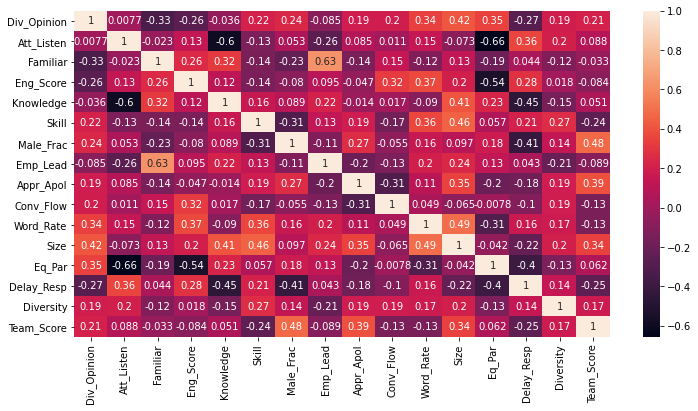

In [ ]:
#exp.corr()
plt.figure(figsize = (12,6))

ax = sns.heatmap(tfidf_exp.corr(), annot=True)

In [ ]:
#Team Score for all members
fin_score_mem = []
score = round(Team_Score['Raw_Avg_Diff'],2)
for i in range(22):
  for j in range(size[i]):
    fin_score_mem.append(score[i])
fin_score_mem

[4.87,
 4.87,
 4.87,
 4.87,
 1.87,
 1.87,
 1.87,
 1.87,
 2.8,
 2.8,
 2.8,
 2.8,
 5.13,
 5.13,
 5.13,
 5.13,
 4.13,
 4.13,
 4.13,
 4.13,
 3.07,
 3.07,
 3.07,
 3.07,
 3.07,
 3.2,
 3.2,
 3.2,
 4.96,
 4.96,
 4.96,
 4.96,
 4.96,
 3.67,
 3.67,
 3.67,
 1.85,
 1.85,
 1.85,
 1.85,
 3.2,
 3.2,
 3.2,
 3.2,
 3.2,
 3.2,
 2.4,
 2.4,
 2.4,
 2.4,
 2.27,
 2.27,
 2.27,
 2.27,
 1.6,
 1.6,
 1.6,
 1.6,
 3.4,
 3.4,
 3.4,
 3.4,
 2.27,
 2.27,
 2.27,
 2.27,
 2.27,
 2.27,
 2.27,
 3.87,
 3.87,
 3.87,
 2.67,
 2.67,
 2.67,
 2.67,
 4.73,
 4.73,
 4.73,
 4.73,
 4.73,
 5.83,
 5.83,
 5.83,
 5.83,
 5.83]

In [ ]:
all_members = pd.DataFrame(team_info)
all_members = all_members.reset_index()
all_members = all_members.drop(['index'], axis = 1)
ID_team = all_members['TeamID']
all_members['Contribution'] = contri_array
all_members['Leadership'] = leader_array
all_members['Knowledge'] = knowl
all_members['Skill'] = ski
all_members['Familiarity'] = familiar_array
all_members['Participation'] = parti
all_members['Word_rate'] = word_rate_array
all_members['Diverse_op'] = div_opinion_per
all_members['Emp_leader'] = emp_lead_per
all_members['Considerate_mem'] = appr_apol_line
all_members['Converse_flow'] = conv_flow_line
all_members['Resp_delay'] = delay_resp_array
# all_members['DM'] = all_metrics['DM']
# all_members['DMP'] = all_metrics['DMP']
# all_members['DMS'] = all_metrics['DMS']
all_members['Attentive_lis'] = attn_listen_per
all_members['Succ_interr'] = all_metrics['frac_succ_interruptions']
all_members['Speak_turns'] = all_metrics['spkngturns']
all_members['Look_at_ppr'] = all_metrics['lookatpaper']
all_members['No_spkr_look_ppr'] = all_metrics['nospkrlookatpaper']
all_members['Speaker_look_ppr'] = all_metrics['spkrlookatpaper']
all_members['atq'] = all_metrics['atq']
all_members['atc'] = all_metrics['atc']
all_members['Gender'] = gender
all_members['Race'] = race
all_members['Team_Score'] = fin_score_mem
all_members['Engagement'] = eng_array
all_members['Knowledge'] = all_members['Knowledge'].astype(float)
all_members['Skill'] = all_members['Skill'].astype(float)
all_members = all_members.fillna(all_members.median())        #Be Mindful - median

all_members = all_members.drop(['ParticipantID', 'TeamID'], axis = 1)
all_mem = all_members.drop(['GroupSize', 'Race', 'Gender'], axis = 1)
all_mem = minmax_scaling(all_mem, columns=all_mem.columns)
all_mem['GroupSize'] = all_members['GroupSize']
all_mem['Race'] = all_members['Race']
all_mem['Gender'] = all_members['Gender']
all_mem['TeamID'] = ID_team
#all_members#.info()

all_members

,GroupSize,Contribution,Leadership,Knowledge,Skill,Familiarity,Participation,Word_rate,Diverse_op,Emp_leader,Considerate_mem,Converse_flow,Resp_delay,Attentive_lis,Succ_interr,Speak_turns,Look_at_ppr,No_spkr_look_ppr,Speaker_look_ppr,atq,atc,Gender,Race,Team_Score,Engagement
0,4,3.00,3.25,2.0,0.0,1.00,3188,21.0,0,0.23,0,2,0.71,39,0.241270,0.254776,0.685226,0.787160,0.841626,0.864655,0.000000,1,White,4.87,76.0
1,4,4.00,3.75,3.0,0.0,1.33,5014,38.0,3,0.38,0,5,0.88,28,0.241270,0.254776,0.685226,0.787160,0.841626,0.864655,0.000000,1,White,4.87,76.0
2,4,3.25,2.75,3.0,0.0,1.67,2122,16.0,2,0.20,0,1,0.53,25,0.241270,0.254776,0.685226,0.787160,0.841626,0.864655,0.000000,0,Asian,4.87,88.0
3,4,3.50,3.00,3.0,0.0,2.00,1835,11.0,2,0.12,0,0,0.43,30,0.241270,0.254776,0.685226,0.787160,0.841626,0.864655,0.000000,1,White/Hispanic,4.87,92.0
4,4,4.50,4.00,3.0,1.0,1.33,4460,39.0,3,0.31,4,0,0.66,49,0.326316,0.274920,0.438671,0.712279,0.666040,0.263239,0.000000,0,Asian,1.87,96.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,5,4.00,4.20,4.0,0.0,2.00,4350,31.5,0,0.39,5,1,0.59,47,0.142857,0.206897,0.394967,0.693775,0.138822,1.069751,0.013322,1,Asian,5.83,92.0
82,5,3.80,2.80,3.0,0.0,1.00,2113,10.0,2,0.04,1,0,0.57,23,0.171429,0.136432,0.992676,0.974638,0.877667,3.660173,0.013935,0,Asian,5.83,88.0
83,5,3.40,2.60,3.0,0.0,2.00,1331,13.5,1,0.15,0,0,0.36,30,0.085714,0.080960,0.838798,0.668623,0.703003,0.236518,0.002297,1,Asian,5.83,88.0
84,5,4.00,3.20,3.0,0.0,1.00,2687,17.0,0,0.62,0,0,0.60,19,0.371429,0.359820,0.775564,0.873192,0.480379,2.410256,0.025113,1,Asian,5.83,100.0


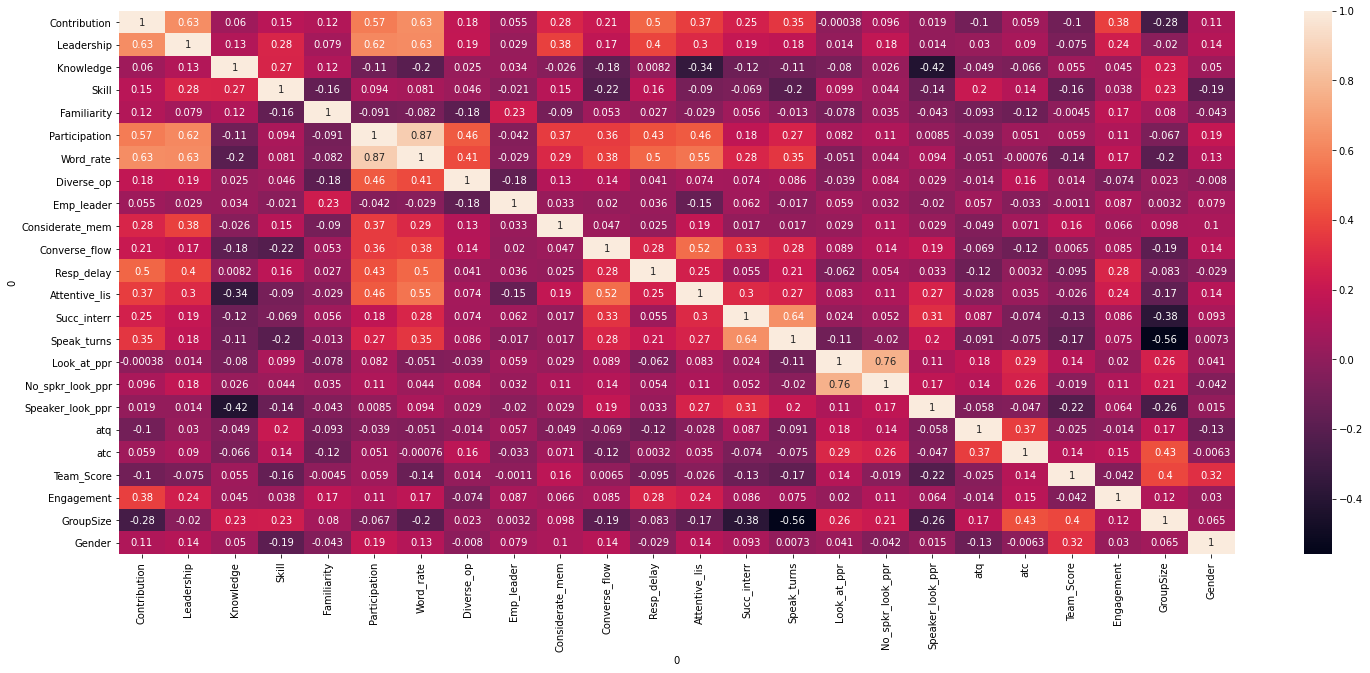

In [ ]:
plt.figure(figsize = (25,10))

ax = sns.heatmap(all_mem.corr(), annot=True)

In [ ]:
all_members['GroupSize'] = all_members['GroupSize'].astype('category')
all_members['Skill'] = all_members['Skill'].astype('category')
all_members['Gender'] = all_members['Gender'].astype('category')
all_members['Race'] = all_members['Race'].astype('category')
all_members['TeamID'] = all_members['TeamID'].astype('category')


In [ ]:
all_members.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   TeamID            86 non-null     category
 1   GroupSize         86 non-null     category
 2   Contribution      86 non-null     float64 
 3   Leadership        86 non-null     float64 
 4   Knowledge         86 non-null     float64 
 5   Skill             86 non-null     category
 6   Familiarity       86 non-null     float64 
 7   Participation     86 non-null     int64   
 8   Word_rate         86 non-null     float64 
 9   Diverse_op        86 non-null     int64   
 10  Emp_leader        86 non-null     float64 
 11  Considerate_mem   86 non-null     int64   
 12  Converse_flow     86 non-null     int64   
 13  Resp_delay        86 non-null     float64 
 14  Attentive_lis     86 non-null     int64   
 15  Succ_interr       86 non-null     float64 
 16  Speak_turns       86 non-nul

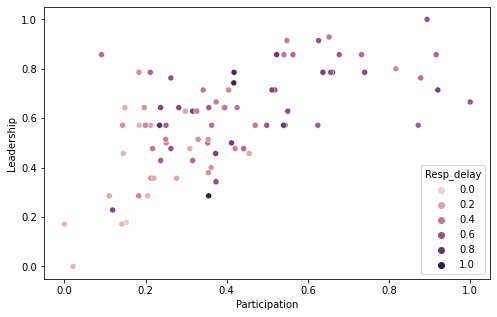

In [ ]:
plt.figure(figsize=(8,5))
sns.scatterplot(x = "Participation", y = "Leadership", hue = "Resp_delay", data = all_mem)

In [ ]:
member_features = all_members.drop(['Race', 'Gender', 'Engagement'], axis = 1)
member_features = minmax_scaling(member_features, columns=member_features.columns)
member_features['Race'] = all_members['Race']
member_features['Gender'] = all_members['Gender']
member_features = pd.get_dummies(member_features, columns = ['Race', 'Gender'])
member_label = all_members['Engagement']


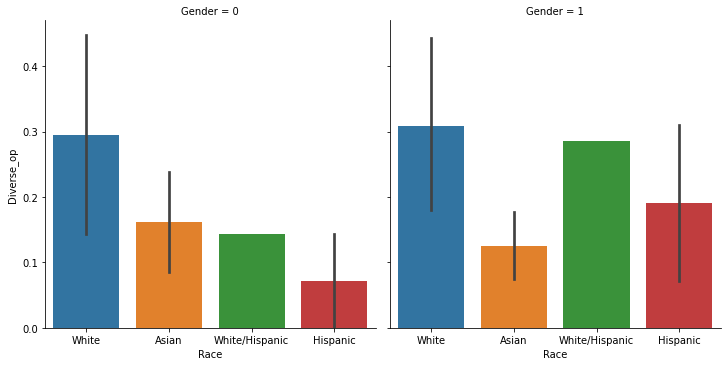

In [ ]:
sns.catplot(x = "Race", y = "Diverse_op", col = "Gender", kind = "bar", data = all_mem)

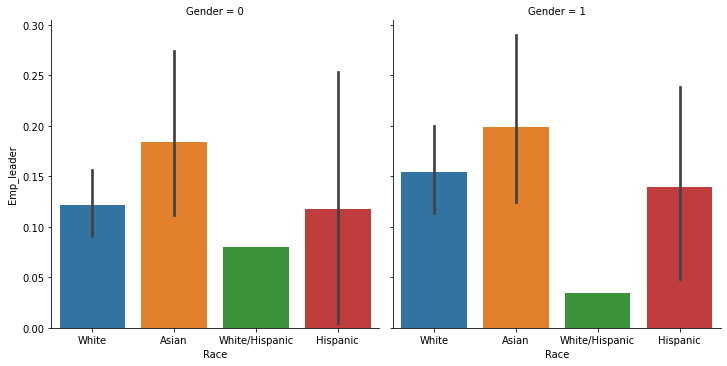

In [ ]:
sns.catplot(x = "Race", y = "Emp_leader", col = "Gender", kind = "bar", data = all_mem)

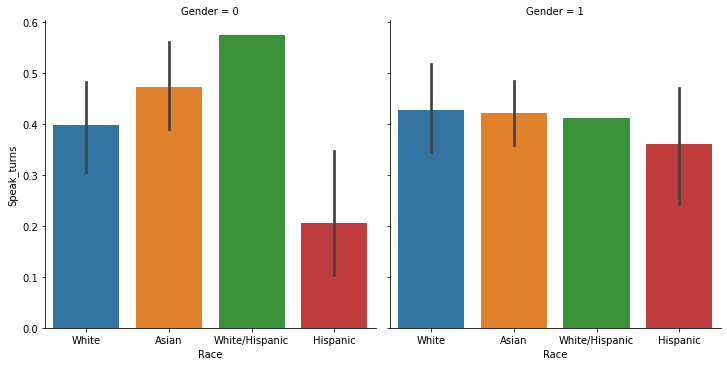

In [ ]:
sns.catplot(x = "Race", y = "Speak_turns", col = "Gender", kind = "bar", data = all_mem)

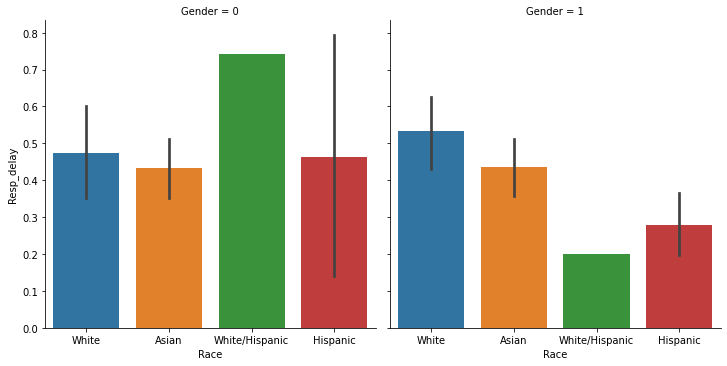

In [ ]:
sns.catplot(x = "Race", y = "Resp_delay", col = "Gender", kind = "bar", data = all_mem)

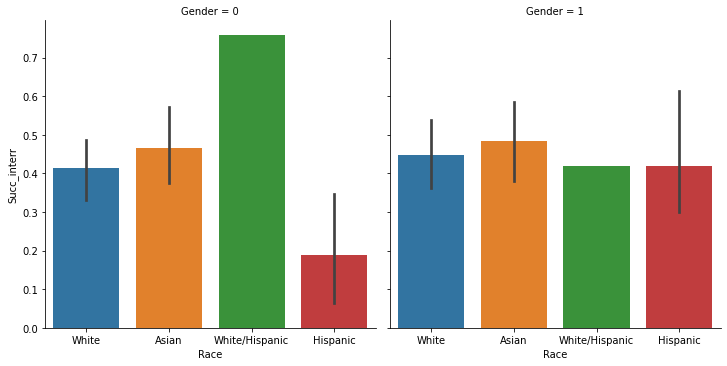

In [ ]:
sns.catplot(x = "Race", y = "Succ_interr", col = "Gender", kind = "bar", data = all_mem)

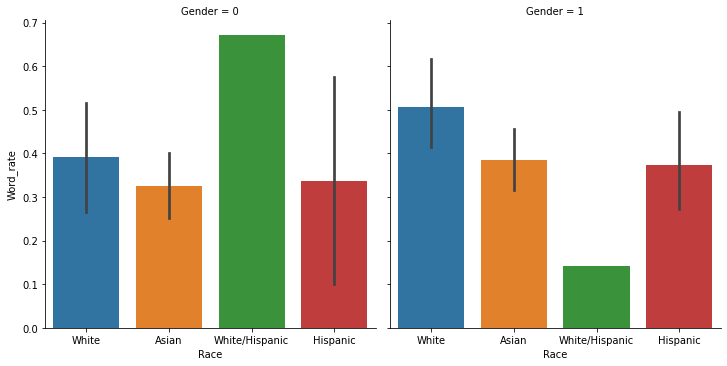

In [ ]:
sns.catplot(x = "Race", y = "Word_rate", col = "Gender", kind = "bar", data = all_mem)

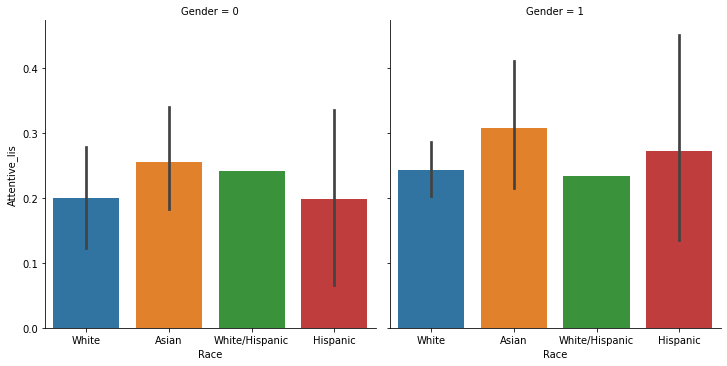

In [ ]:
sns.catplot(x = "Race", y = "Attentive_lis", col = "Gender", kind = "bar", data = all_mem)

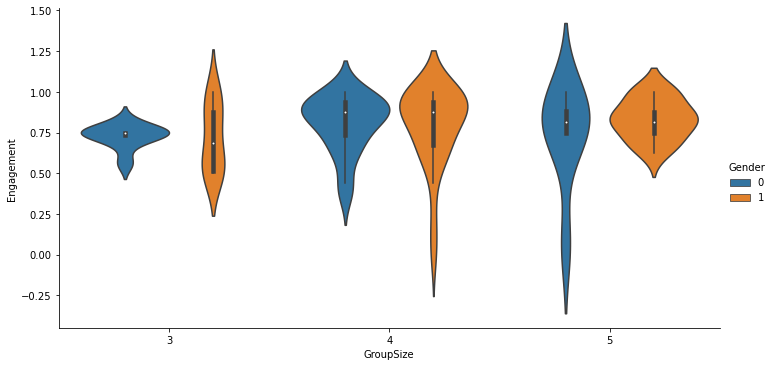

In [ ]:
sns.catplot(x="GroupSize", y="Engagement", hue = "Gender", kind="violin", data=all_mem, height = 5, aspect = 2)

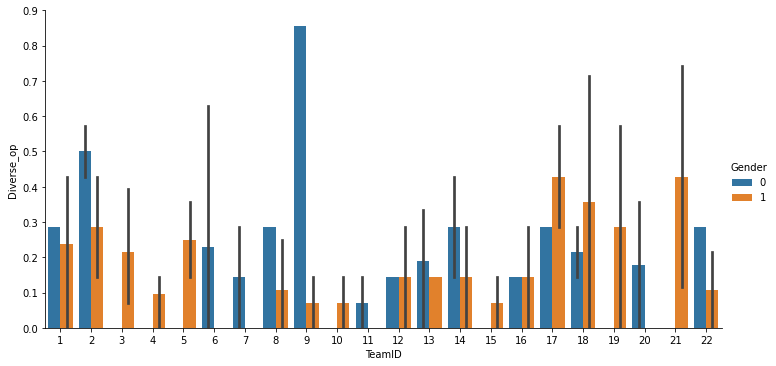

In [ ]:
sns.catplot(x="TeamID", y="Diverse_op", hue = "Gender", kind="bar", data=all_mem, height = 5, aspect = 2)

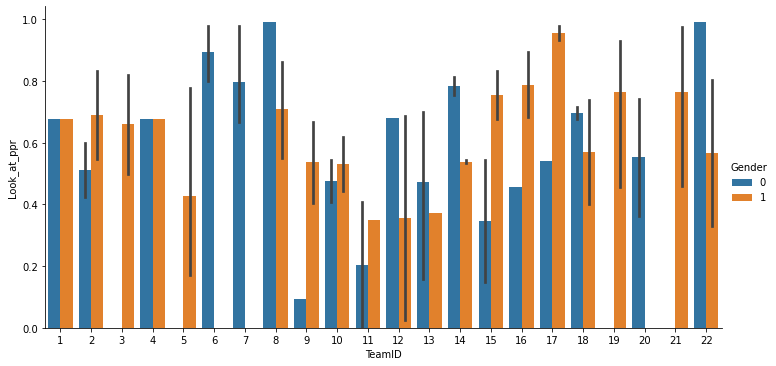

In [ ]:
sns.catplot(x="TeamID", y="Look_at_ppr", hue = "Gender", kind="bar", data=all_mem, height = 5, aspect = 2)

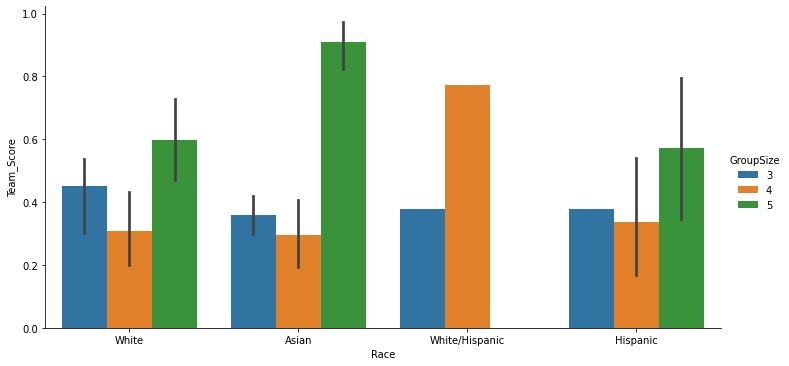

In [ ]:
sns.catplot(x="Race", y="Team_Score", hue = "GroupSize", kind="bar", data=all_mem, height = 5, aspect = 2)

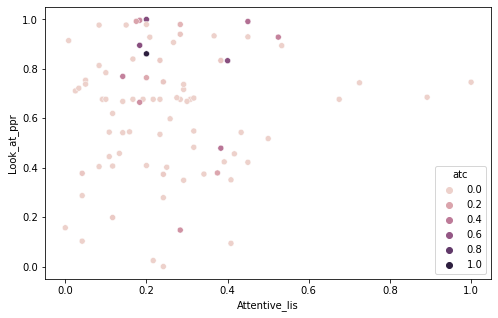

In [ ]:
plt.figure(figsize=(8,5))
sns.scatterplot(x = "Attentive_lis", y = "Look_at_ppr", hue = "atc", data = all_mem)

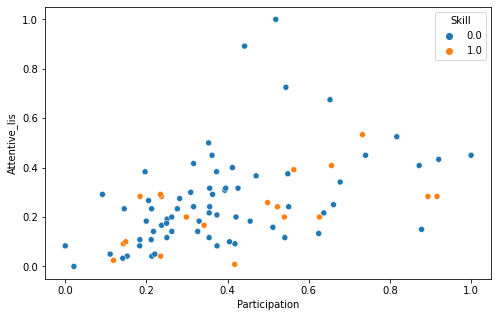

In [ ]:
plt.figure(figsize=(8,5))
sns.scatterplot(x = "Participation", y = "Attentive_lis", hue = "Skill", data = all_mem)

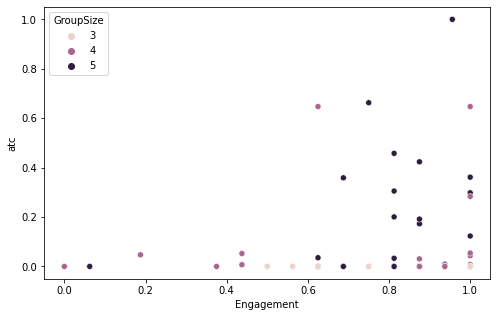

In [ ]:
plt.figure(figsize=(8,5))
sns.scatterplot(x = "Engagement", y = "atc", hue = "GroupSize", data = all_mem)

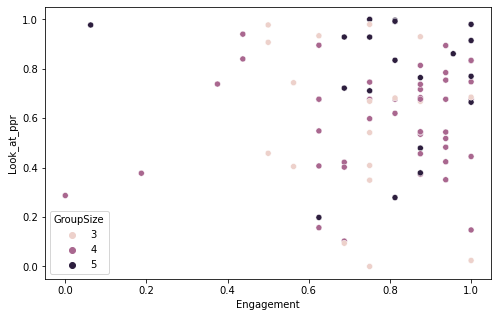

In [ ]:
plt.figure(figsize=(8,5))
sns.scatterplot(x = "Engagement", y = "Look_at_ppr", hue = "GroupSize", data = all_mem)

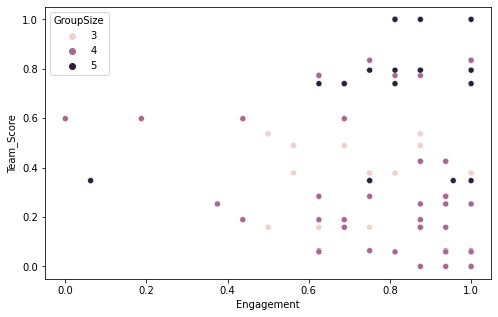

In [ ]:
plt.figure(figsize=(8,5))
sns.scatterplot(x = "Engagement", y = "Team_Score", hue = "GroupSize", data = all_mem)

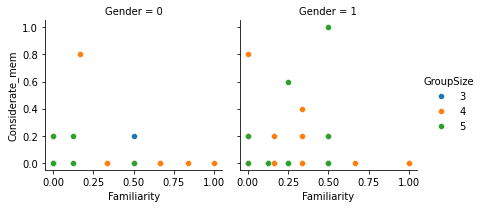

In [ ]:
g = sns.FacetGrid(all_mem, col="Gender",  hue="GroupSize")
g.map(sns.scatterplot, "Familiarity", "Considerate_mem")
g.add_legend()

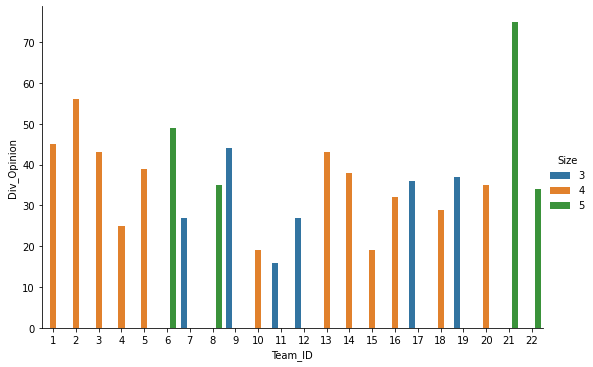

In [ ]:
######################################## Diverse opinions by group size ##############################
sns.catplot(x = "Team_ID", y = "Div_Opinion", kind = "bar", hue = "Size", data = diverse_op_mod, aspect=1.5, height=5)
#ax2 = sns.lineplot(x= "Team_ID", y='Team_Score', data=exp)
#ax2.set_ylim(ymin=0)
#ax2.set_xlim(xmin=-1)

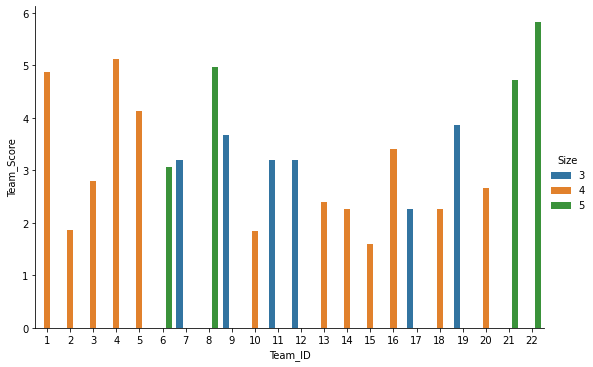

In [ ]:
##### Plotting Team Size wrt Score
sns.catplot(x = "Team_ID", y = "Team_Score", kind = "bar", hue = "Size", data = diverse_op_mod, aspect=1.5, height=5)


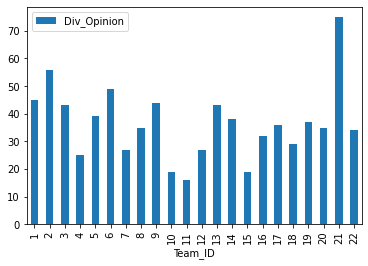

In [ ]:
#Plotting diversified opinion index
diverse_op_mod.plot.bar(x = 'Team_ID', y = 'Div_Opinion')

(0.0, 78.75)

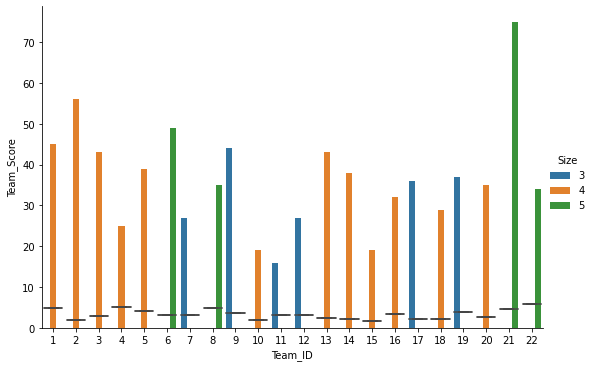

In [ ]:
ax1 = sns.catplot(x = "Team_ID", y = "Div_Opinion", kind = "bar", hue = "Size", data = diverse_op_mod, aspect=1.5, height=5)
ax2 = sns.boxplot(x='Team_ID', y='Team_Score', data=diverse_op_mod) 
ax2.set_ylim(ymin=0)